In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import datetime as dt
import plotly.graph_objects as go

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.recognition_evaluators' in sys.modules:
    del sys.modules['pygents.recognition_evaluators']

from pygents.aigents_api import TextMetrics, load_ngrams, punct, tokenize_re, build_ngrams, Learner
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot, plot_bar_from_list, \
    build_triple_list, build_triple_matrix, plot_bar_from_list_minmax
from pygents.util import dictcount, contains_seq, agg_min_max_avg_mpe
from pygents.recognition_evaluators import df2labeled, language_metrics, our_evaluator_test, our_evaluator_tm, our_evaluator_top, \
    our_evaluator_true, our_evaluator_false, our_evaluator_random, pre_rec_f1_from_counts, evaluate_tm_df, evaluate_metrics, evaluate_model, \
    full_test_circle, dictval, our_evaluator_top1

grand_t0 = dt.datetime.now()

[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from datasets import load_dataset

DS = 'Babakan24'

# dataset: https://huggingface.co/datasets/halilbabacan/combined_synthetic_cognitive_distortions/tree/main
ds = load_dataset(
    "halilbabacan/combined_synthetic_cognitive_distortions",
    split="train",
)

df = ds.to_pandas()
df = df.rename(columns={'text': 'Patient Question', 'label': 'Dominant Distortion'})
df.insert(1, 'Distorted part', value = np.nan)
df.insert(3, 'Secondary Distortion (Optional)', value = np.nan)
# Remove the row with index 738 because it contains a NaN in the text column
df = df.drop(index=738)


mapping = {
    "Labelling":            "Labeling",
    "Mental Filter":        "Mental filter",
    "Should Statements":    "Should statements",
    "All-or-Nothing Thinking": "All-or-nothing thinking"
}

df['Dominant Distortion'] = df['Dominant Distortion'].map(mapping).fillna(df['Dominant Distortion'])

df

Patient Question  Distorted part  \
0     John walked past me without saying a word He m...             NaN   
1     During the meeting, Sarah didn't look at me on...             NaN   
2     Mike didn't respond to my text right away He m...             NaN   
3     Jessica didn't smile when she saw me She must ...             NaN   
4     Tom didn't invite me to his party He must not ...             NaN   
...                                                 ...             ...   
4526  I’m a 21 year old female. I spent most of my l...             NaN   
4527  Now I am at university my peers around me all ...             NaN   
4528  He claims he’s severely depressed and has outb...             NaN   
4529  From the U.S.: I am a 21 year old woman who ha...             NaN   
4530  I recently moved out on my ex-roommate because...             NaN   

     Dominant Distortion  Secondary Distortion (Optional)  
0           Mind Reading                              NaN  
1           Mind Reading                              NaN  
2           Mind Reading                              NaN  
3           Mind Reading                              NaN  
4           Mind Reading                              NaN  
...                  ...                              ...  
4526       No Distortion                              NaN  
4527  Overgeneralization                              NaN  
4528       Mental filter                              NaN  
4529       No Distortion                              NaN  
4530       No Distortion                              NaN  

[4530 rows x 4 columns]

# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [3]:
test_babacan_multiclass_path = './temp/test/'
model_name = 'multi-df-babacan-split-5'
inclusion_thresholds = [0,10,20,30,40,50,60,70,80,90]
detection_thresholds = [10,20,30,40,50,60,70,80,90]
selection_metrics = ['F','UF','FN','UFN','TF-IDF','FCR','CFR','MR','NLMI']
n_max_values = [1,2,3,4,5]
splits = [0,1,2]


In [4]:
results = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_babacan_multiclass_path,f'{model_name}-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top,accumulator=accumulator)
    results.append(accumulator)


Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Disto

In [5]:
summary = []
for l1,l2,l3 in zip(results[0],results[1],results[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, DT
NM, IT, SM, DT = summary[0][:4] 
print(NM, IT, SM, DT)
print()
print([s for s in summary if s[2]=='FCR'][:1])
print([s for s in summary if s[2]=='FN'][:1])
print([s for s in summary if s[2]=='MR'][:1])
print()
for s in summary[:20]:
    print(s)

2 90 MR 40

[(3, 80, 'FCR', 70, 0.8108891184118457, 0.8151585522181606, 0.8132525875906113, 0.19374621651620794)]
[(3, 80, 'FN', 70, 0.8120608355835628, 0.8151585522181606, 0.8134053074497531, 0.14369587152924176)]
[(2, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)]

(2, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(3, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(4, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(5, 90, 'MR', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(2, 90, 'NLMI', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(3, 90, 'NLMI', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)
(4, 90, 'NLMI', 40, 0.8610742344075677, 0.9080631911872221, 0.888908346726792, 2.0875127281470047)


Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})


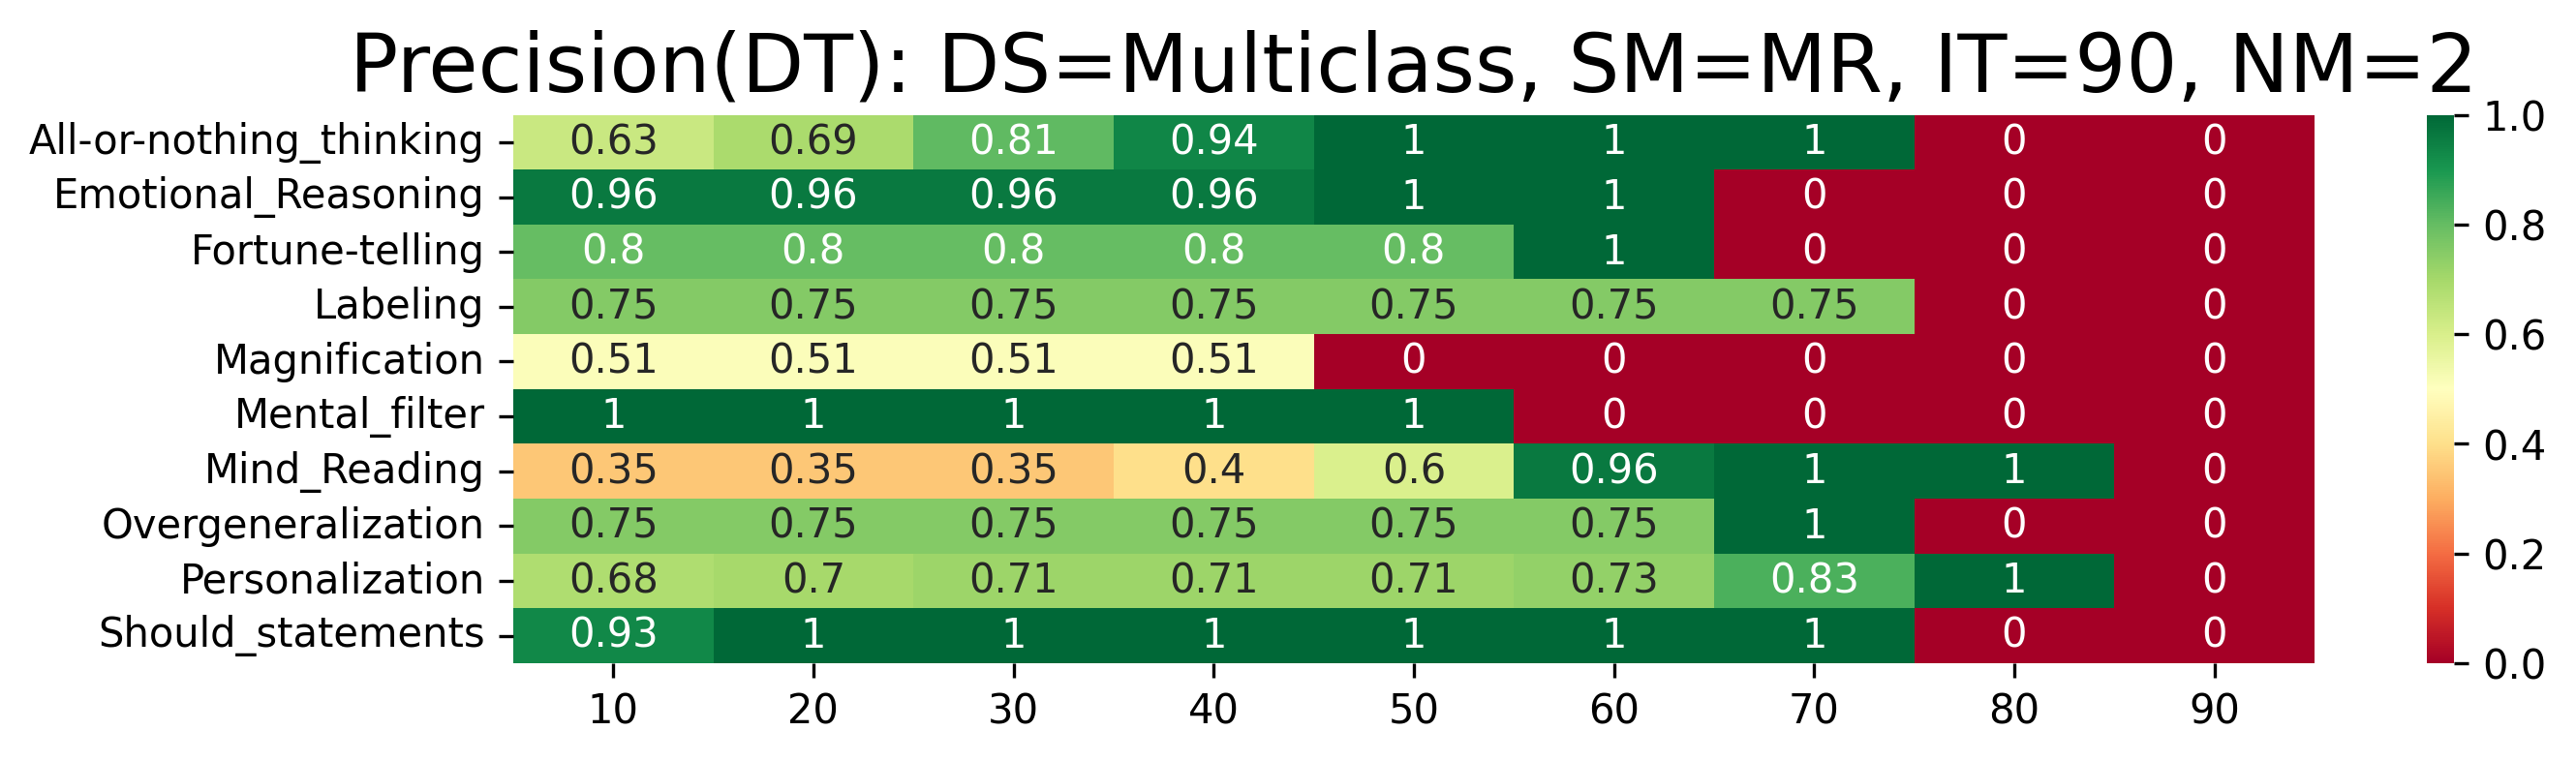

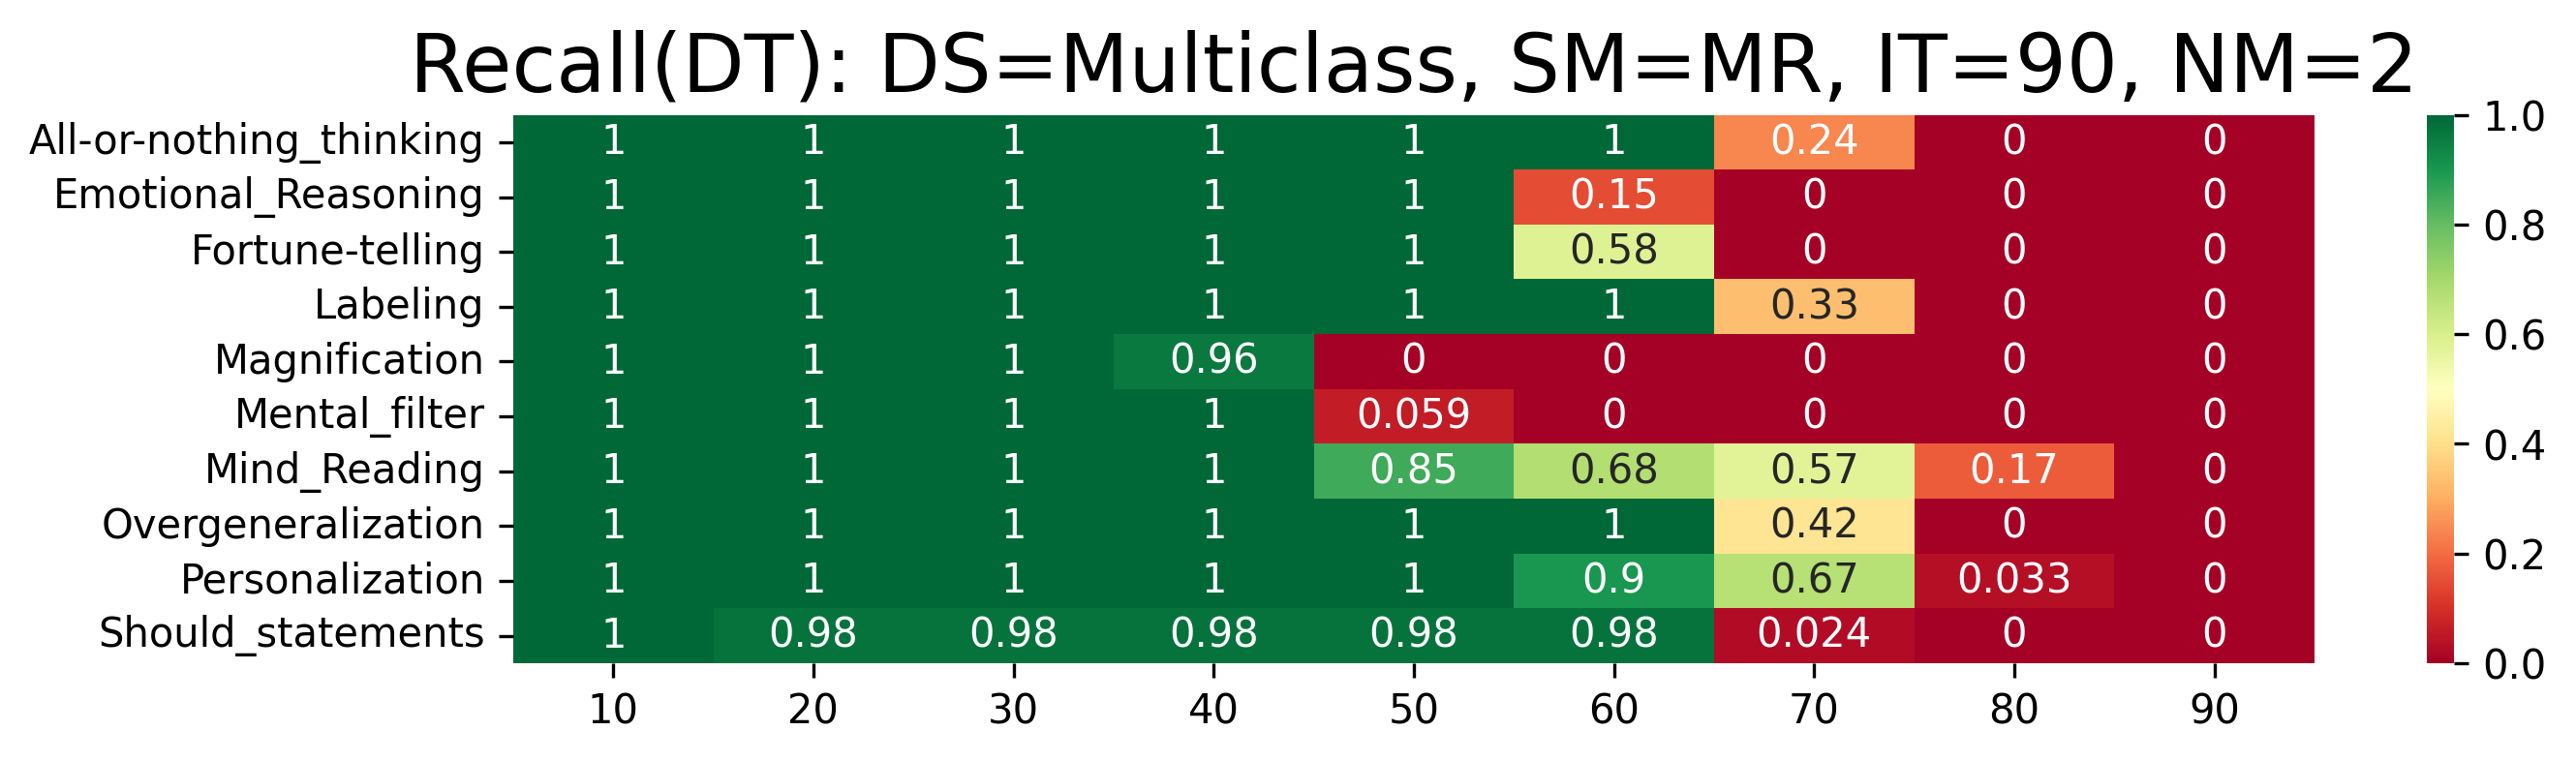

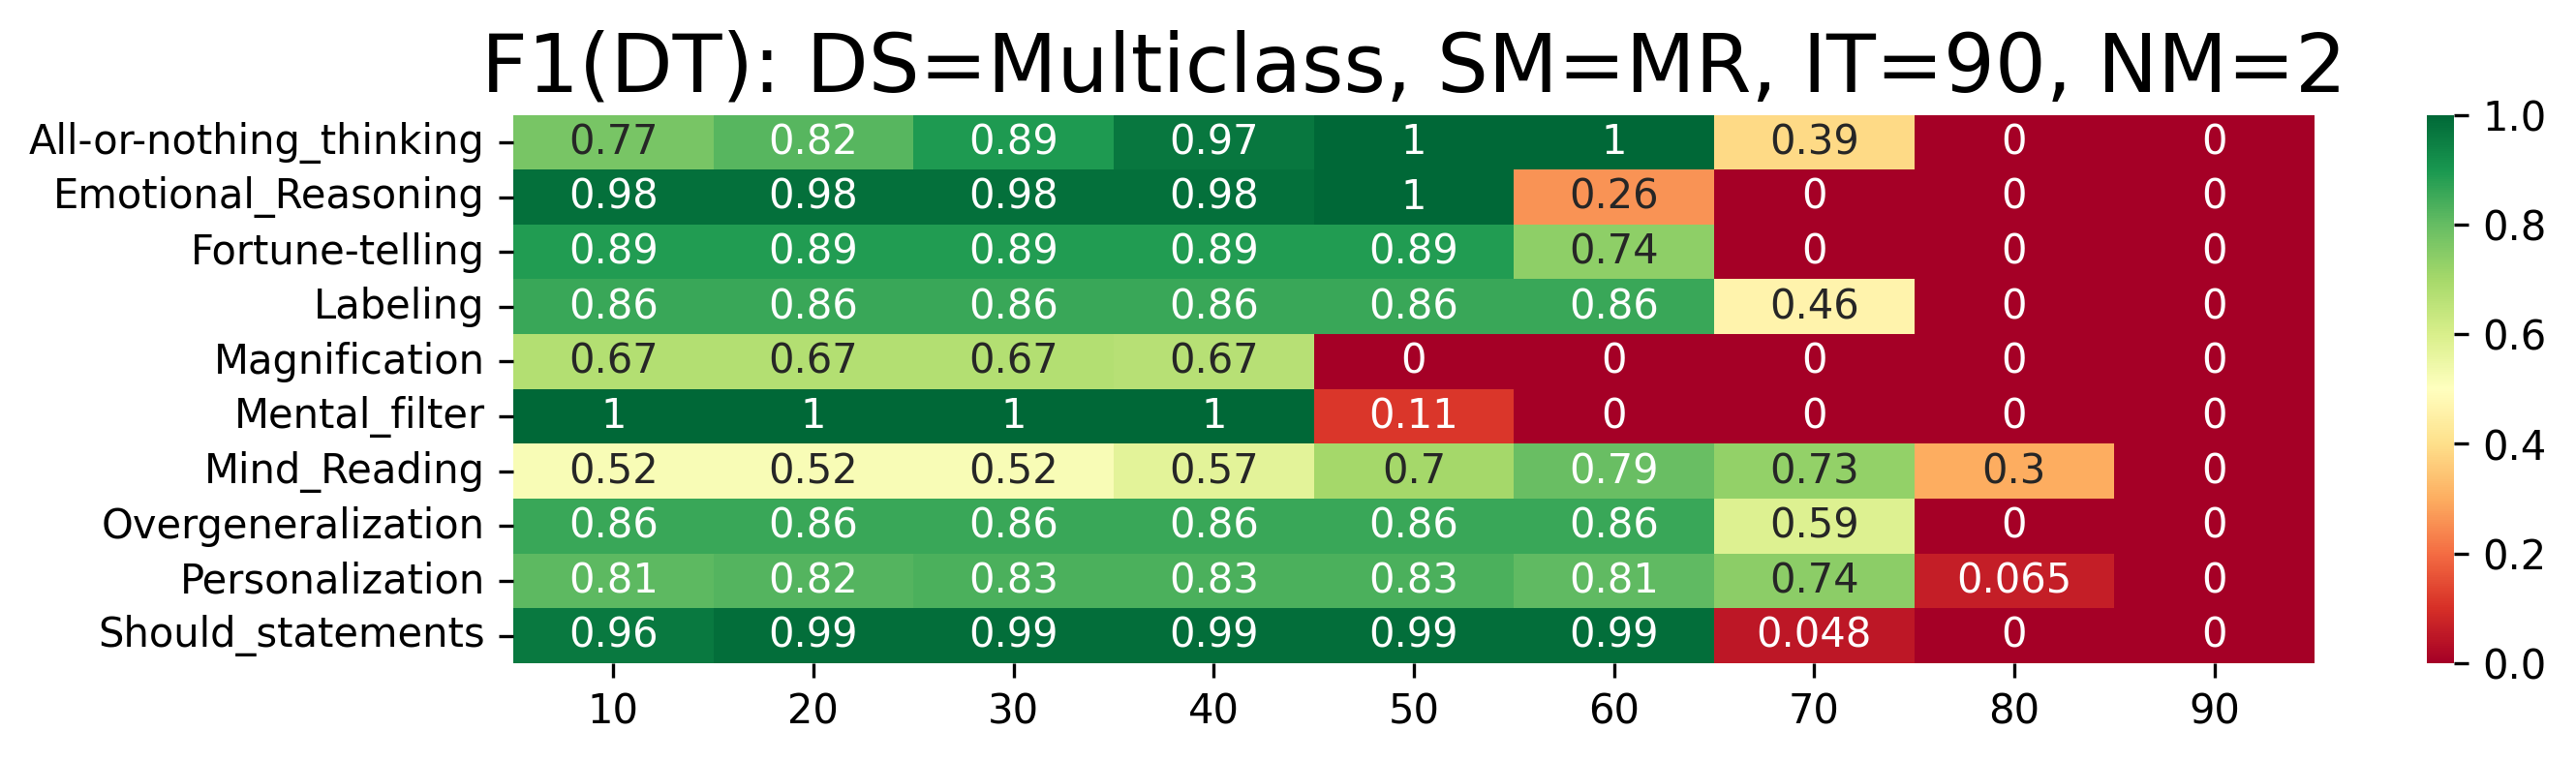

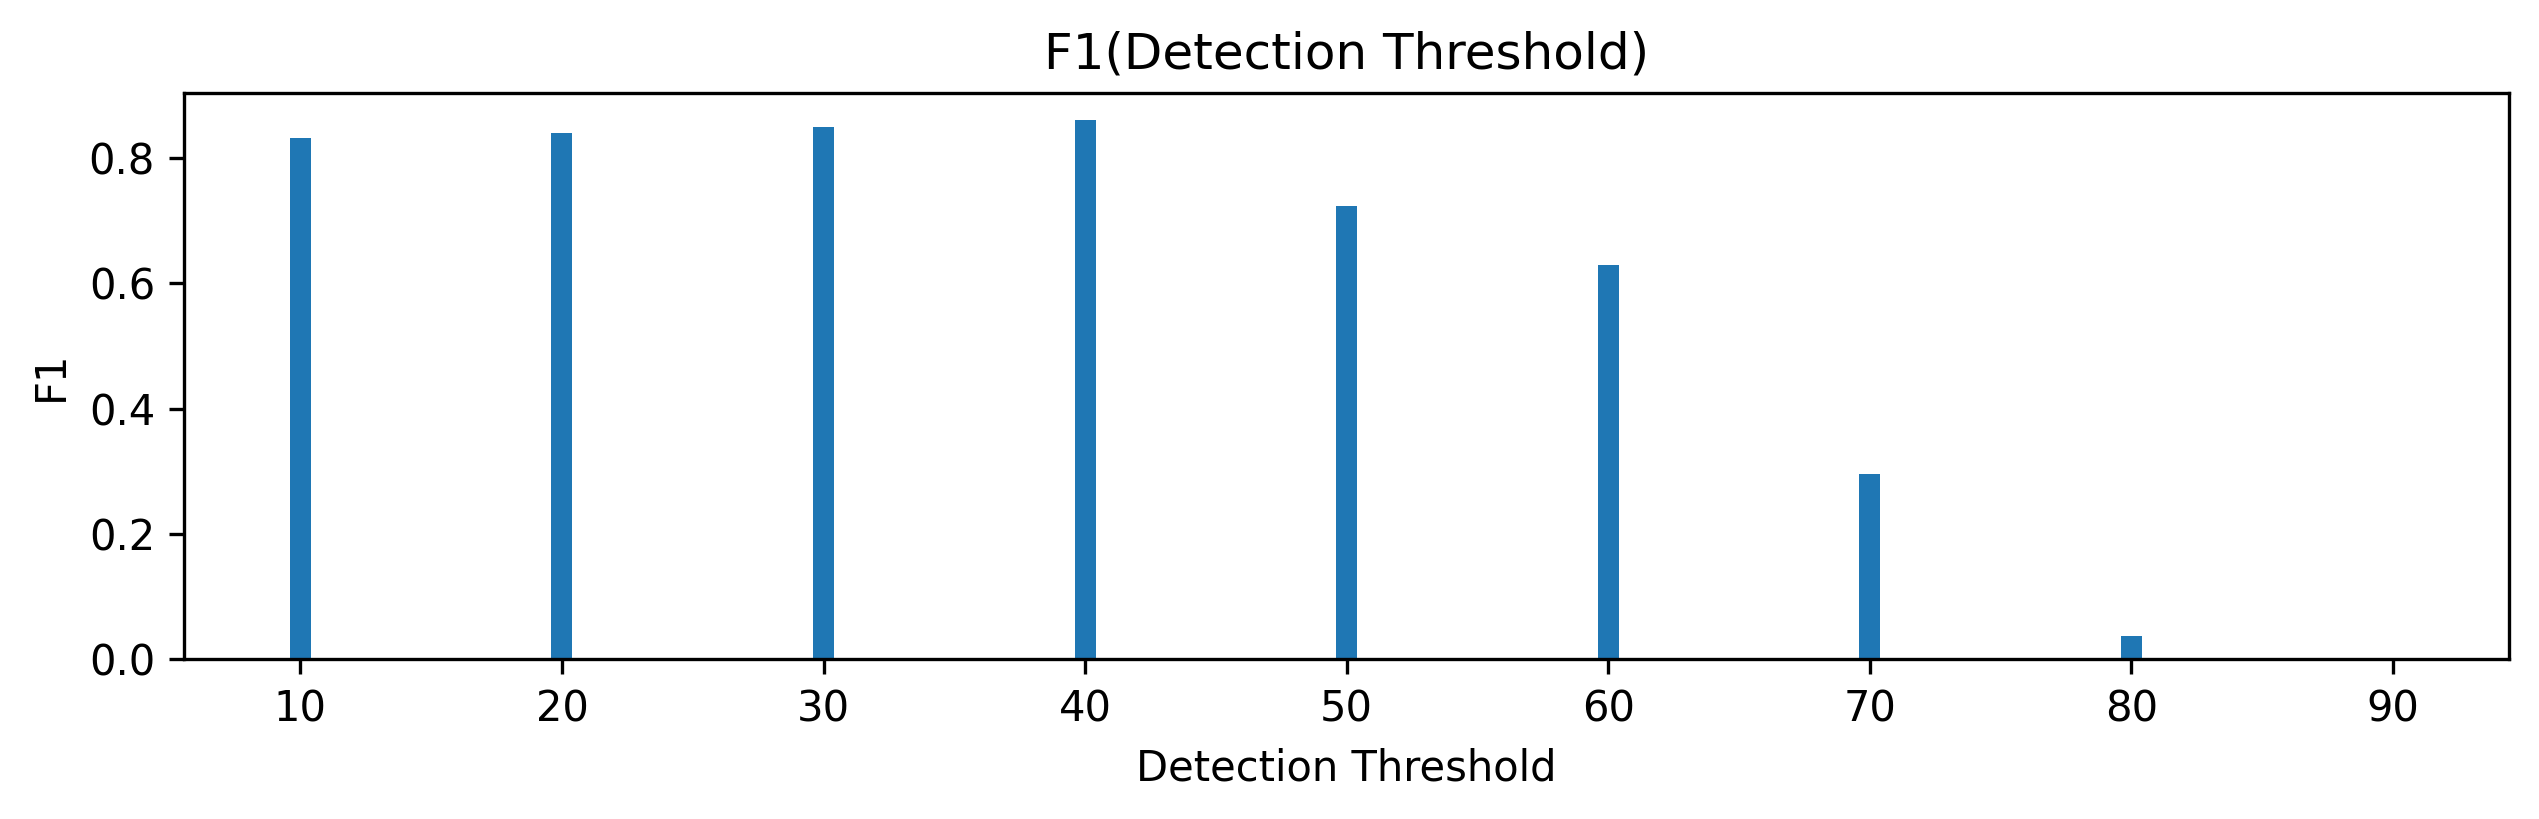

In [6]:
shift = 0
full_test_circle(df,test_babacan_multiclass_path,f'{model_name}-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top)

Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})


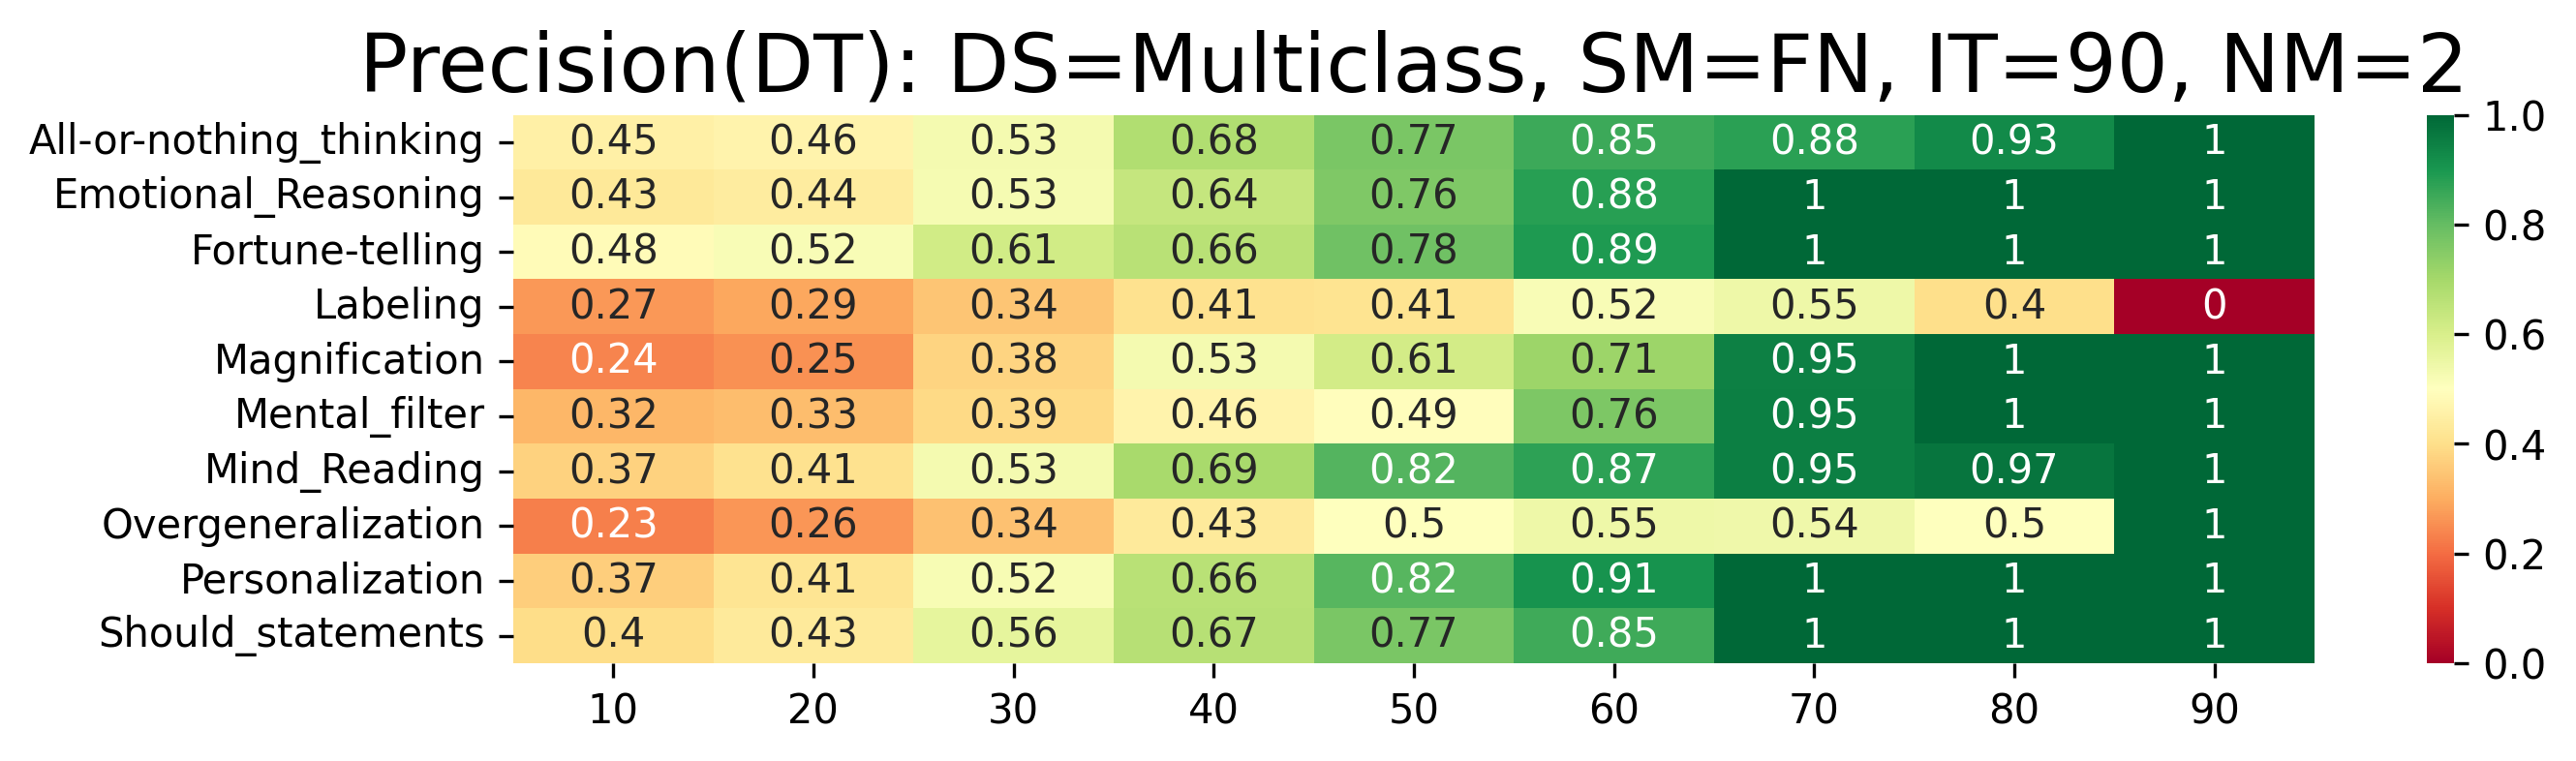

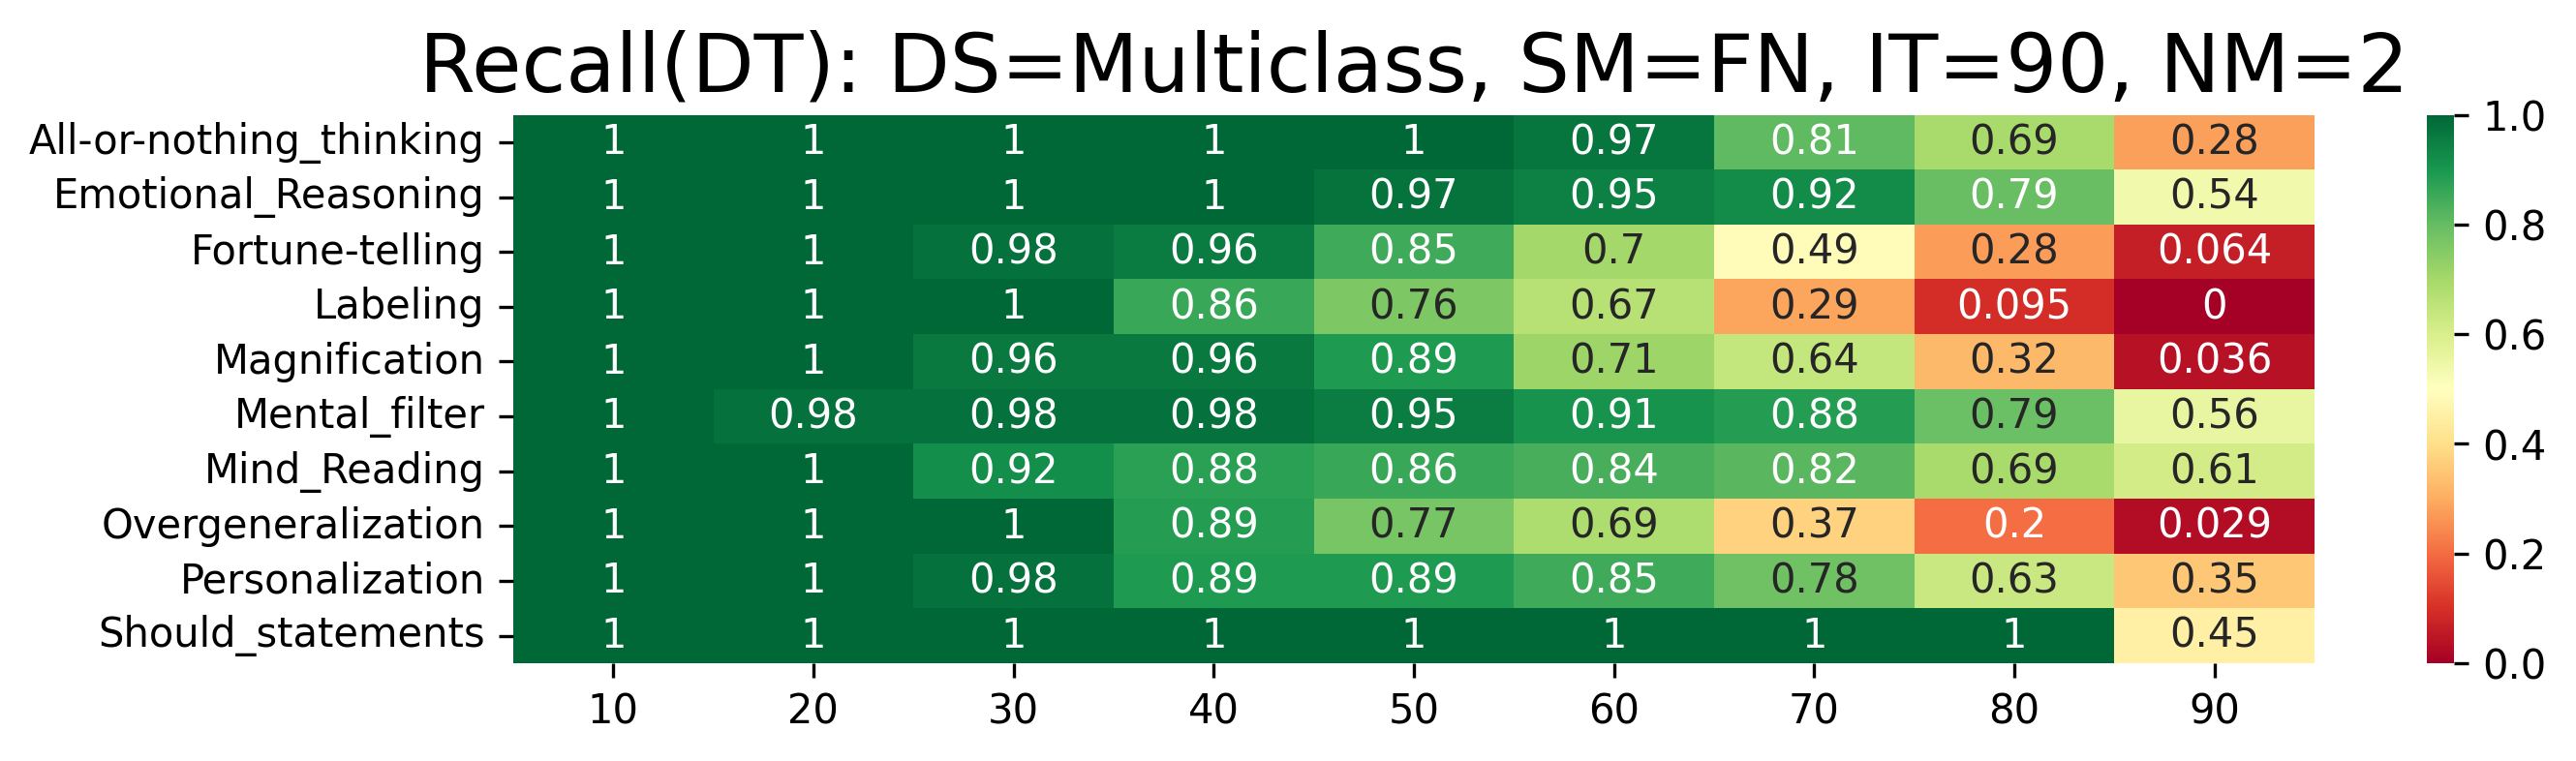

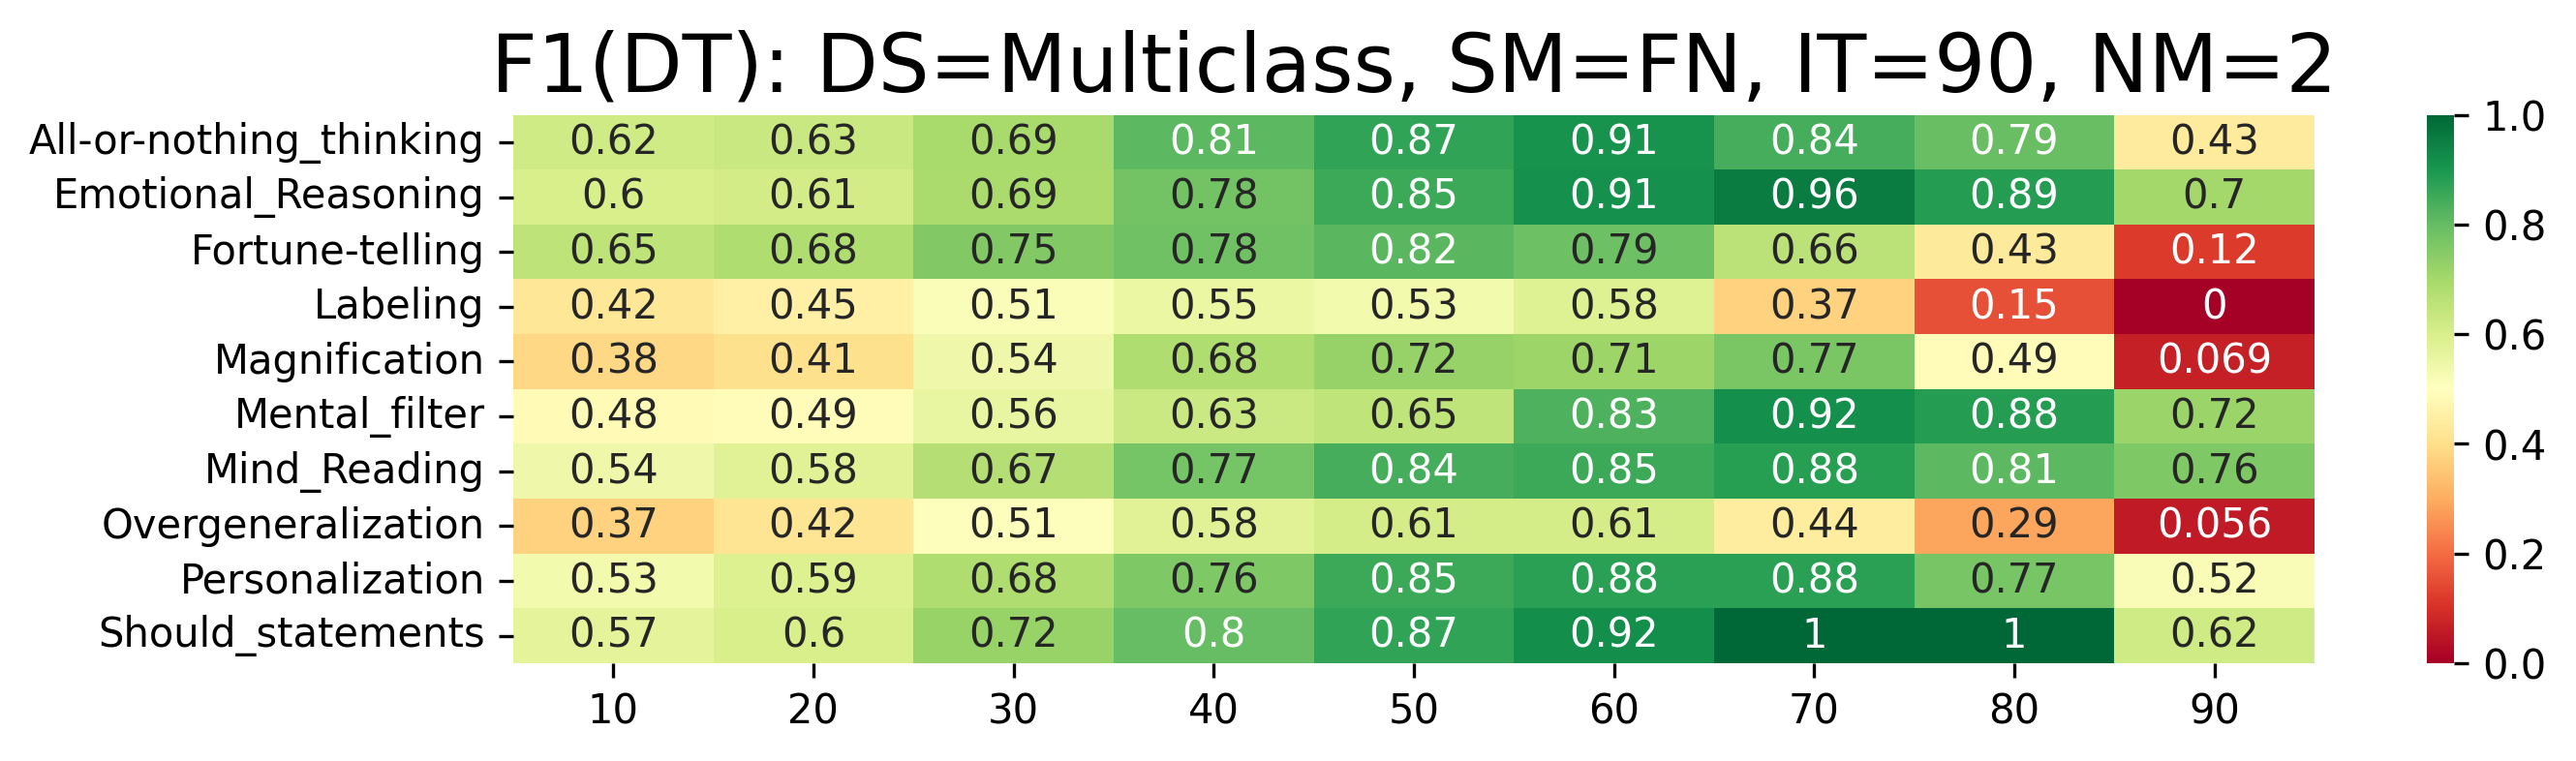

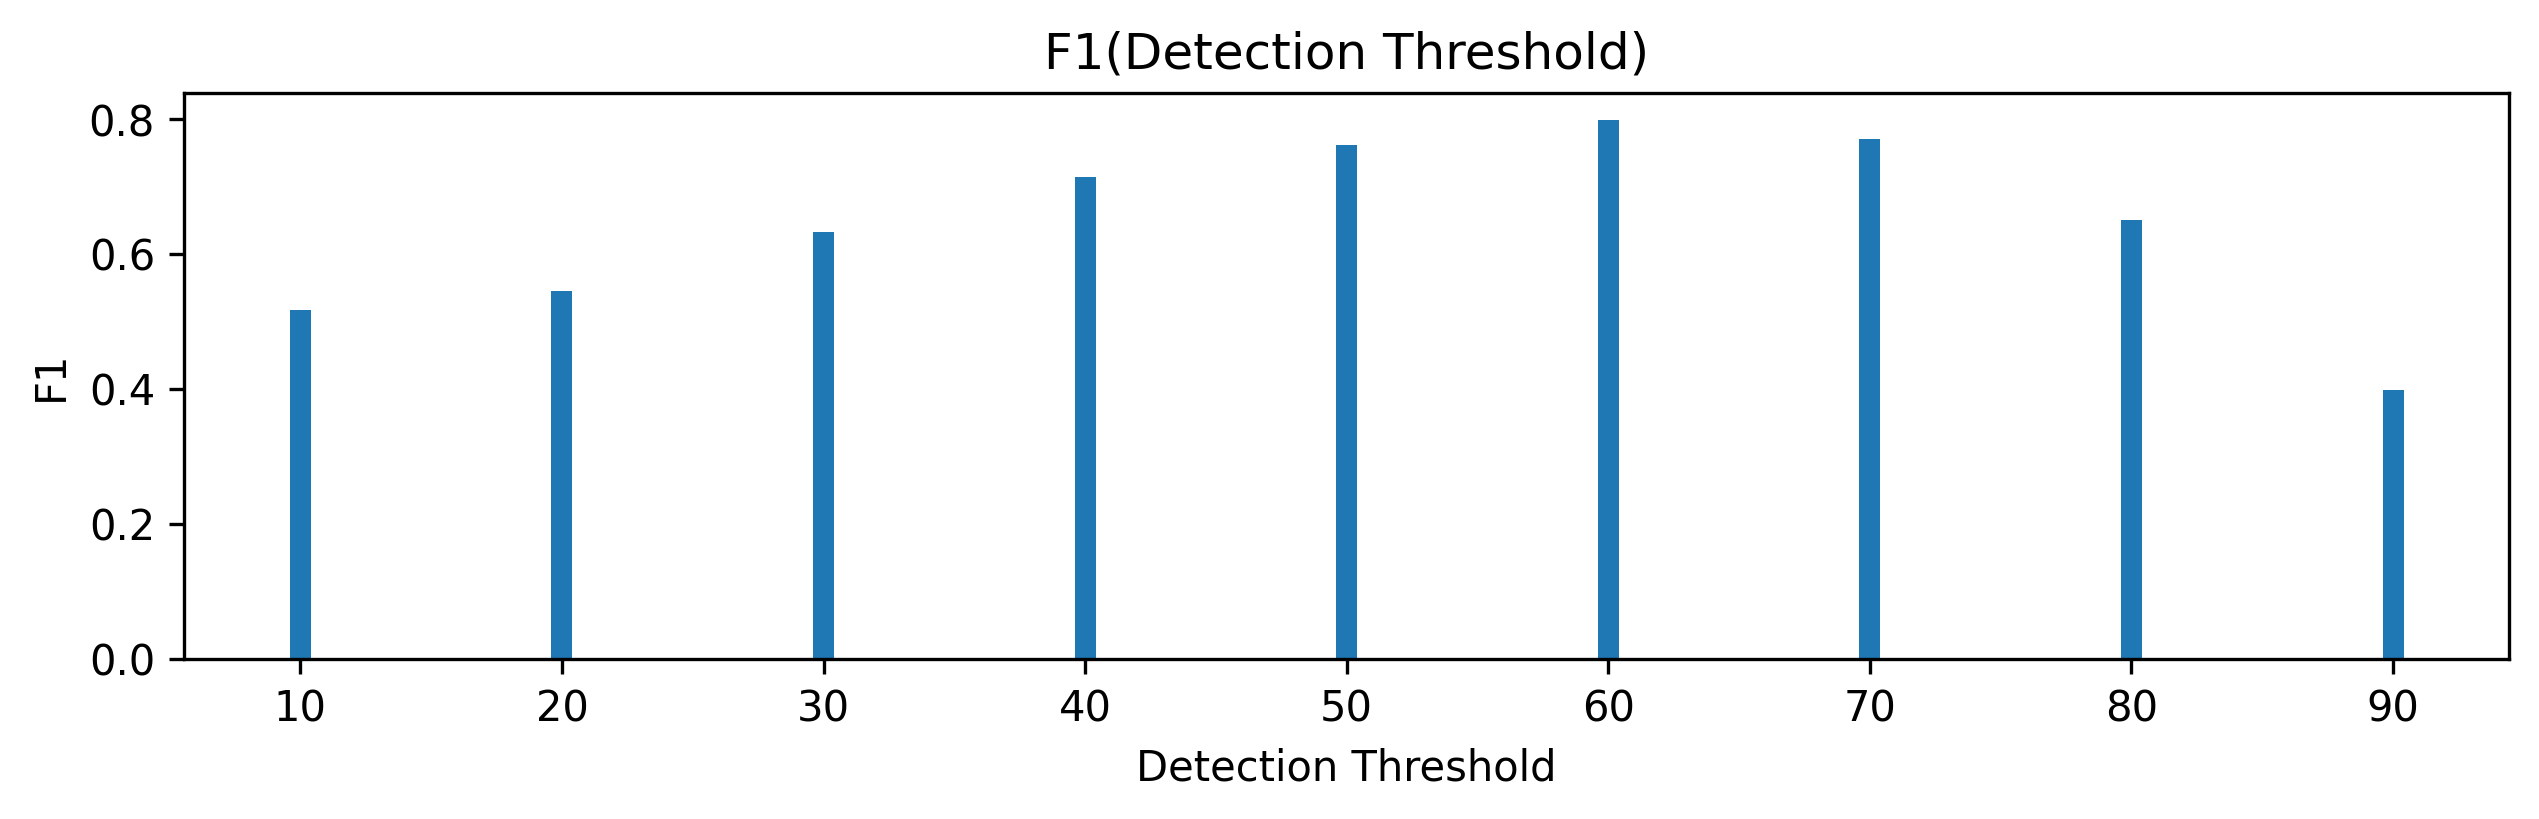

In [7]:
shift = 0
full_test_circle(df,test_babacan_multiclass_path,f'{model_name}-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = ['FN'],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top)

In [8]:
results1 = []
for shift in splits:
    accumulator = []
    for n_max in n_max_values:
        full_test_circle(df,test_babacan_multiclass_path,f'{model_name}-{shift+1}',
                validation_fraction=5,inclusion_thresholds=inclusion_thresholds,
                detection_thresholds=detection_thresholds,n_max=n_max, selection_metrics = selection_metrics,
                all_scores=False,averages=False,split_shift=shift,evaluator=our_evaluator_top1,accumulator=accumulator)
    results1.append(accumulator)


Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Disto

In [9]:
summary = []
for l1,l2,l3 in zip(results1[0],results1[1],results1[2]):
    summary.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary = sorted(summary, key=lambda x: (-x[6],x[2],x[0],-x[1],x[3])) # sort by -F1avg, SM, NM, -IT, RT
NM, IT, SM, DT = summary[0][:4] 
print(NM, IT, SM, DT)
print()
print([s for s in summary if s[2]=='MR'][:1])
print([s for s in summary if s[2]=='FCR'][:1])
print([s for s in summary if s[2]=='FN'][:1])
print()
for s in summary[:20]:
    print(s)

4 80 MR 40

[(4, 80, 'MR', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)]
[(2, 70, 'FCR', 60, 0.8667840370779727, 0.8849712398029915, 0.8743744669660739, 0.80795076840753)]
[(2, 70, 'FN', 60, 0.8667840370779727, 0.8849712398029915, 0.8743744669660739, 0.80795076840753)]

(4, 80, 'MR', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(5, 80, 'MR', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(4, 80, 'NLMI', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(5, 80, 'NLMI', 40, 0.8871984818076772, 0.9164508106001581, 0.9027830220931646, 1.1508516741452492)
(4, 90, 'MR', 40, 0.8852032836559772, 0.9150539852033326, 0.9017342476588895, 1.2221608192458375)
(5, 90, 'MR', 40, 0.8852032836559772, 0.9150539852033326, 0.9017342476588895, 1.2221608192458375)
(4, 90, 'NLMI', 40, 0.8852032836559772, 0.9150539852033326, 0.9017342476588895, 1.2221608192458375

Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})


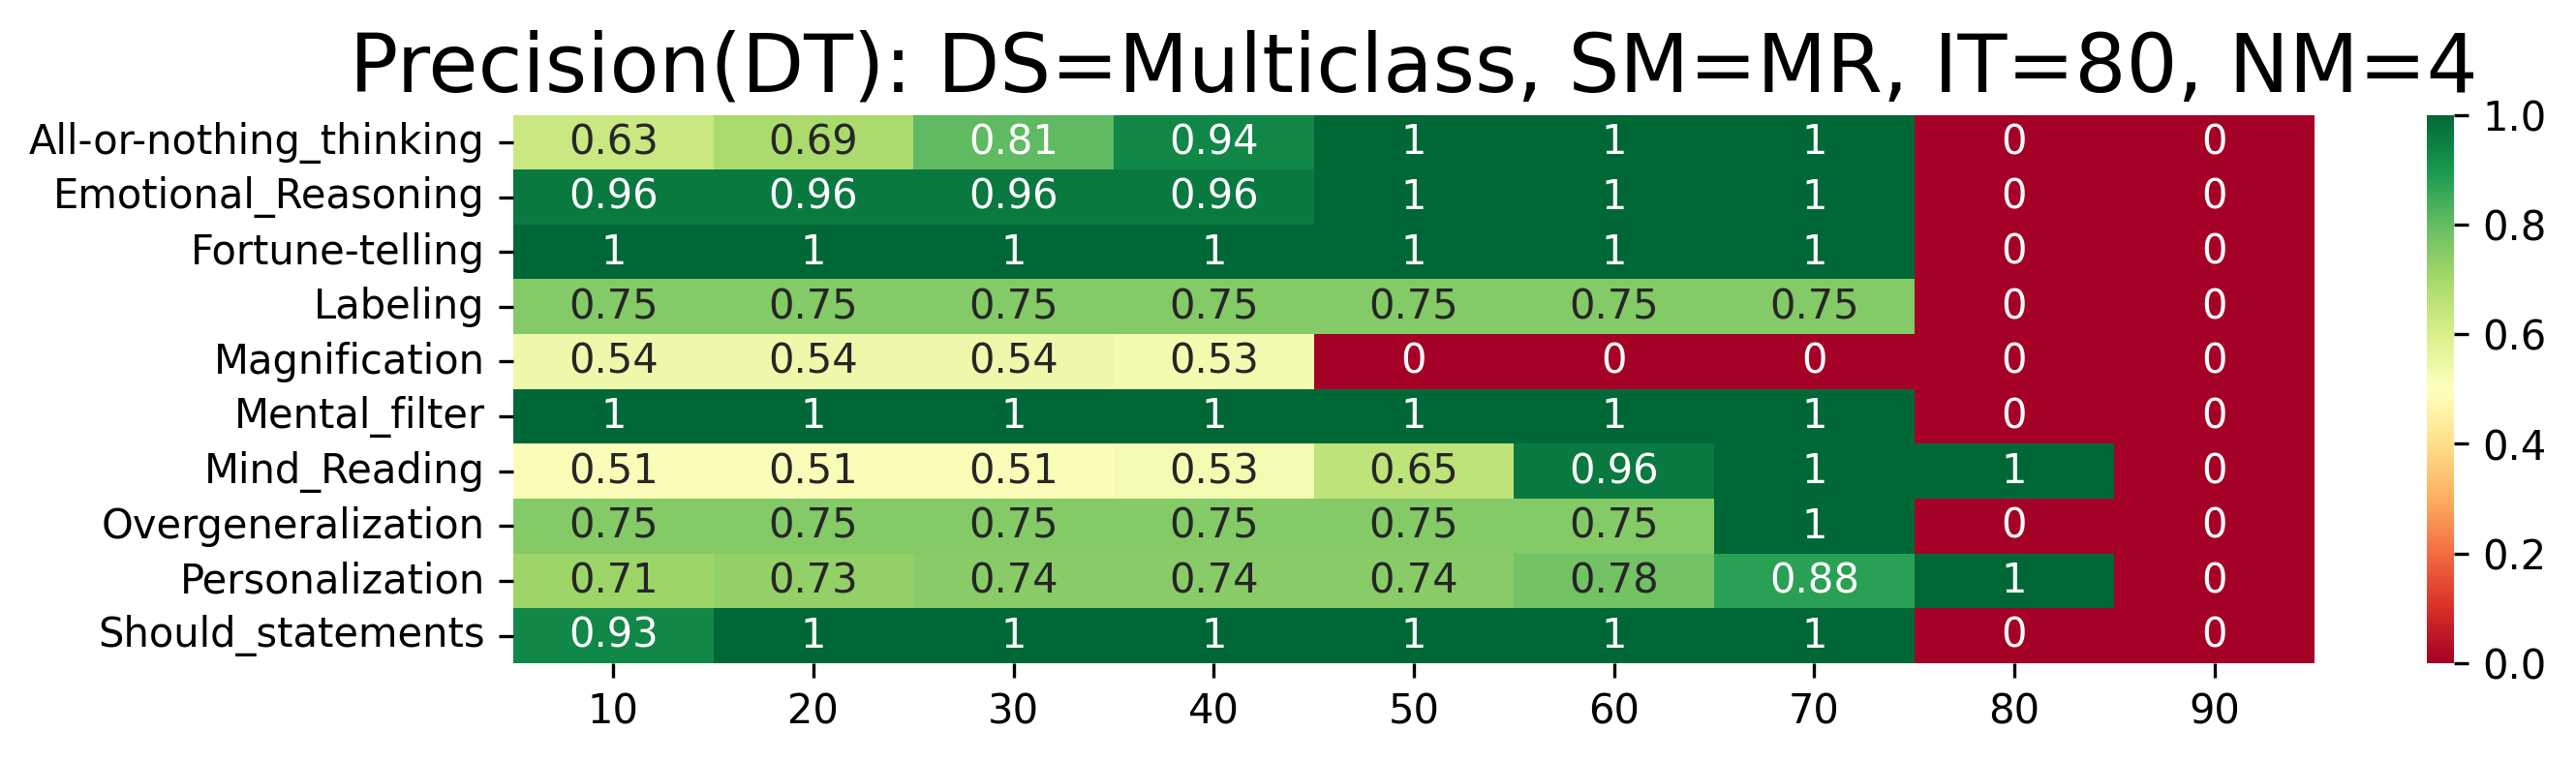

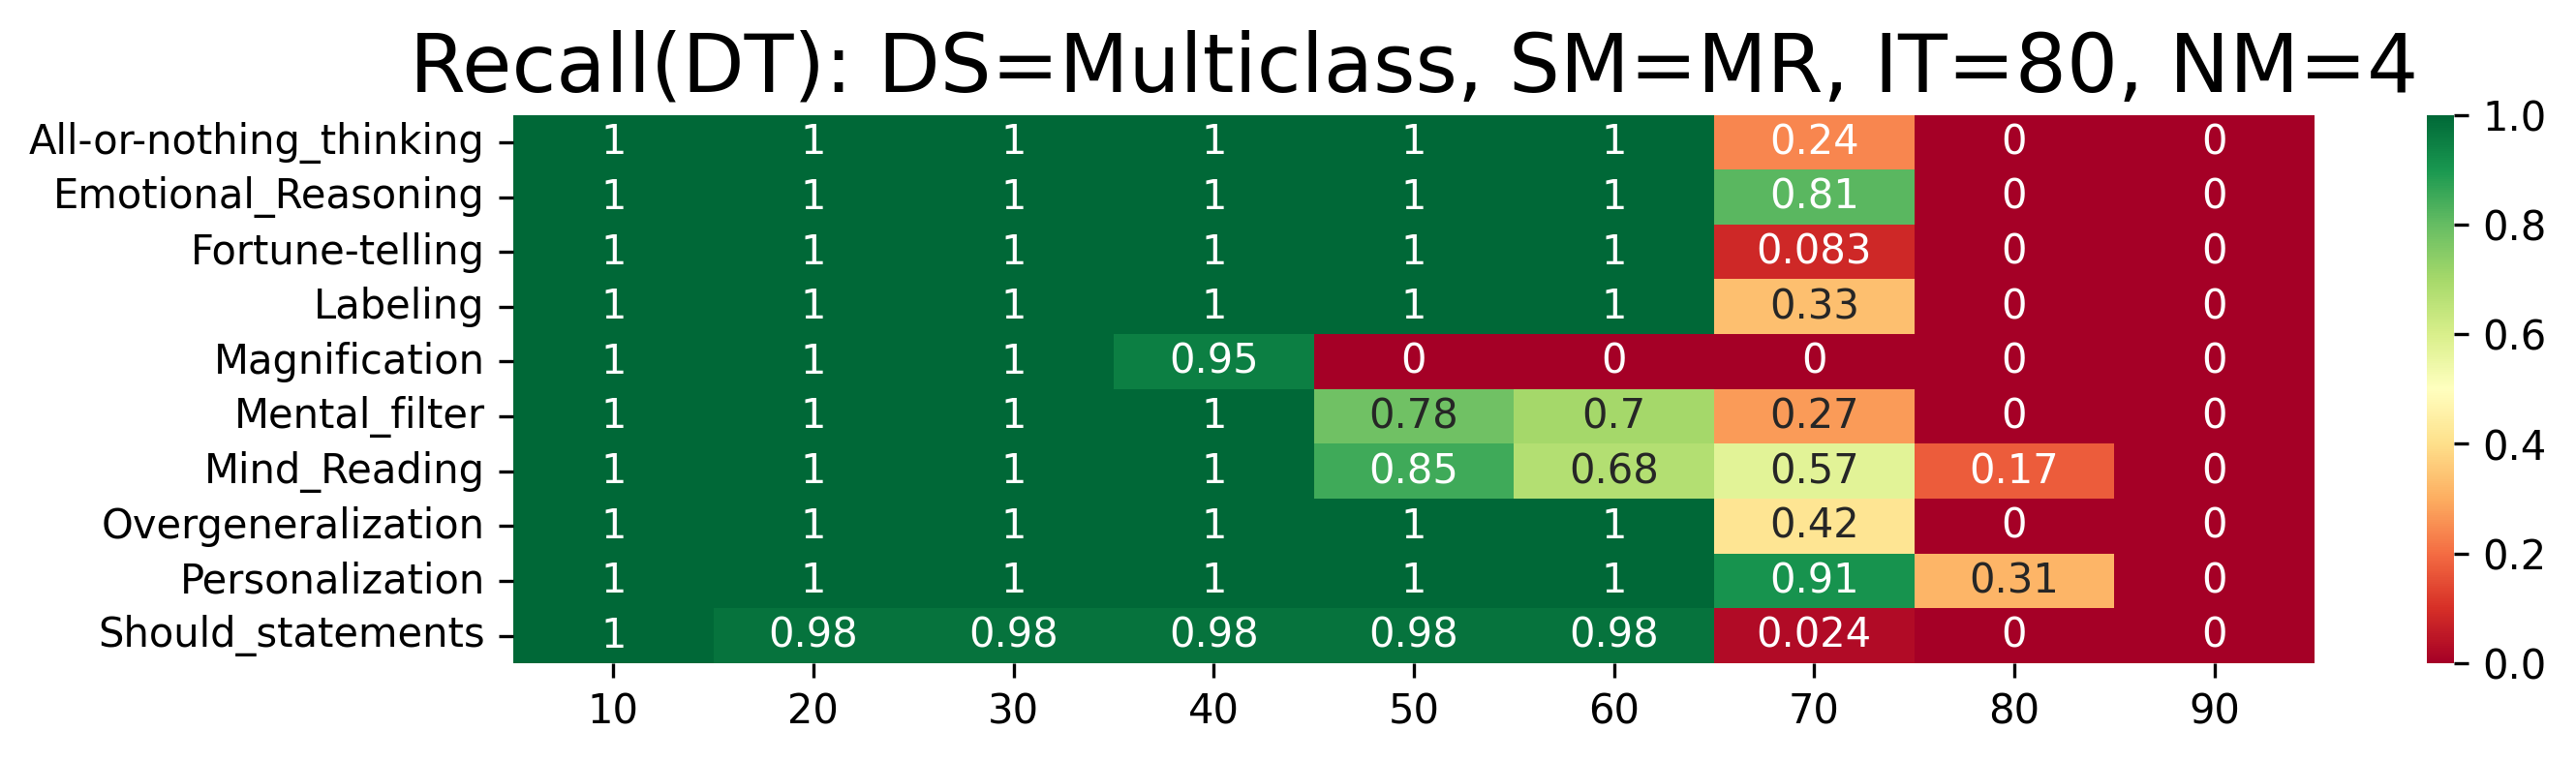

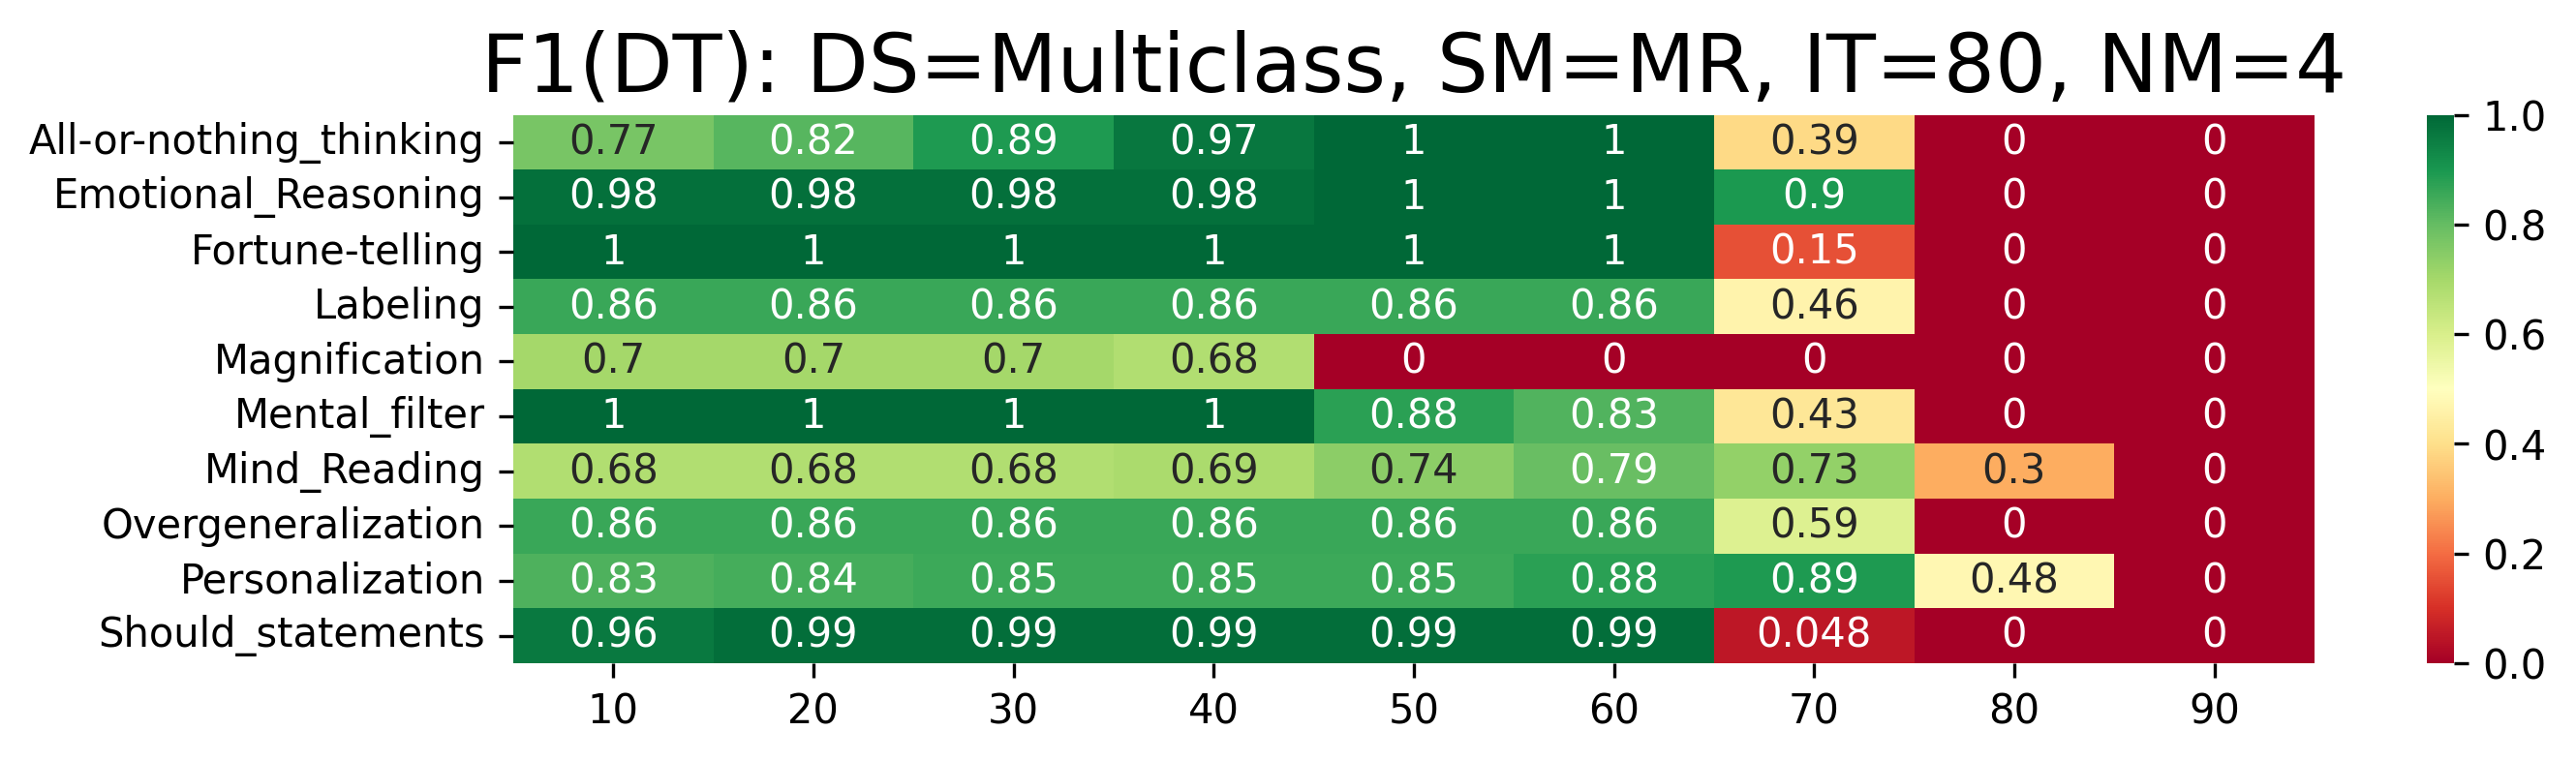

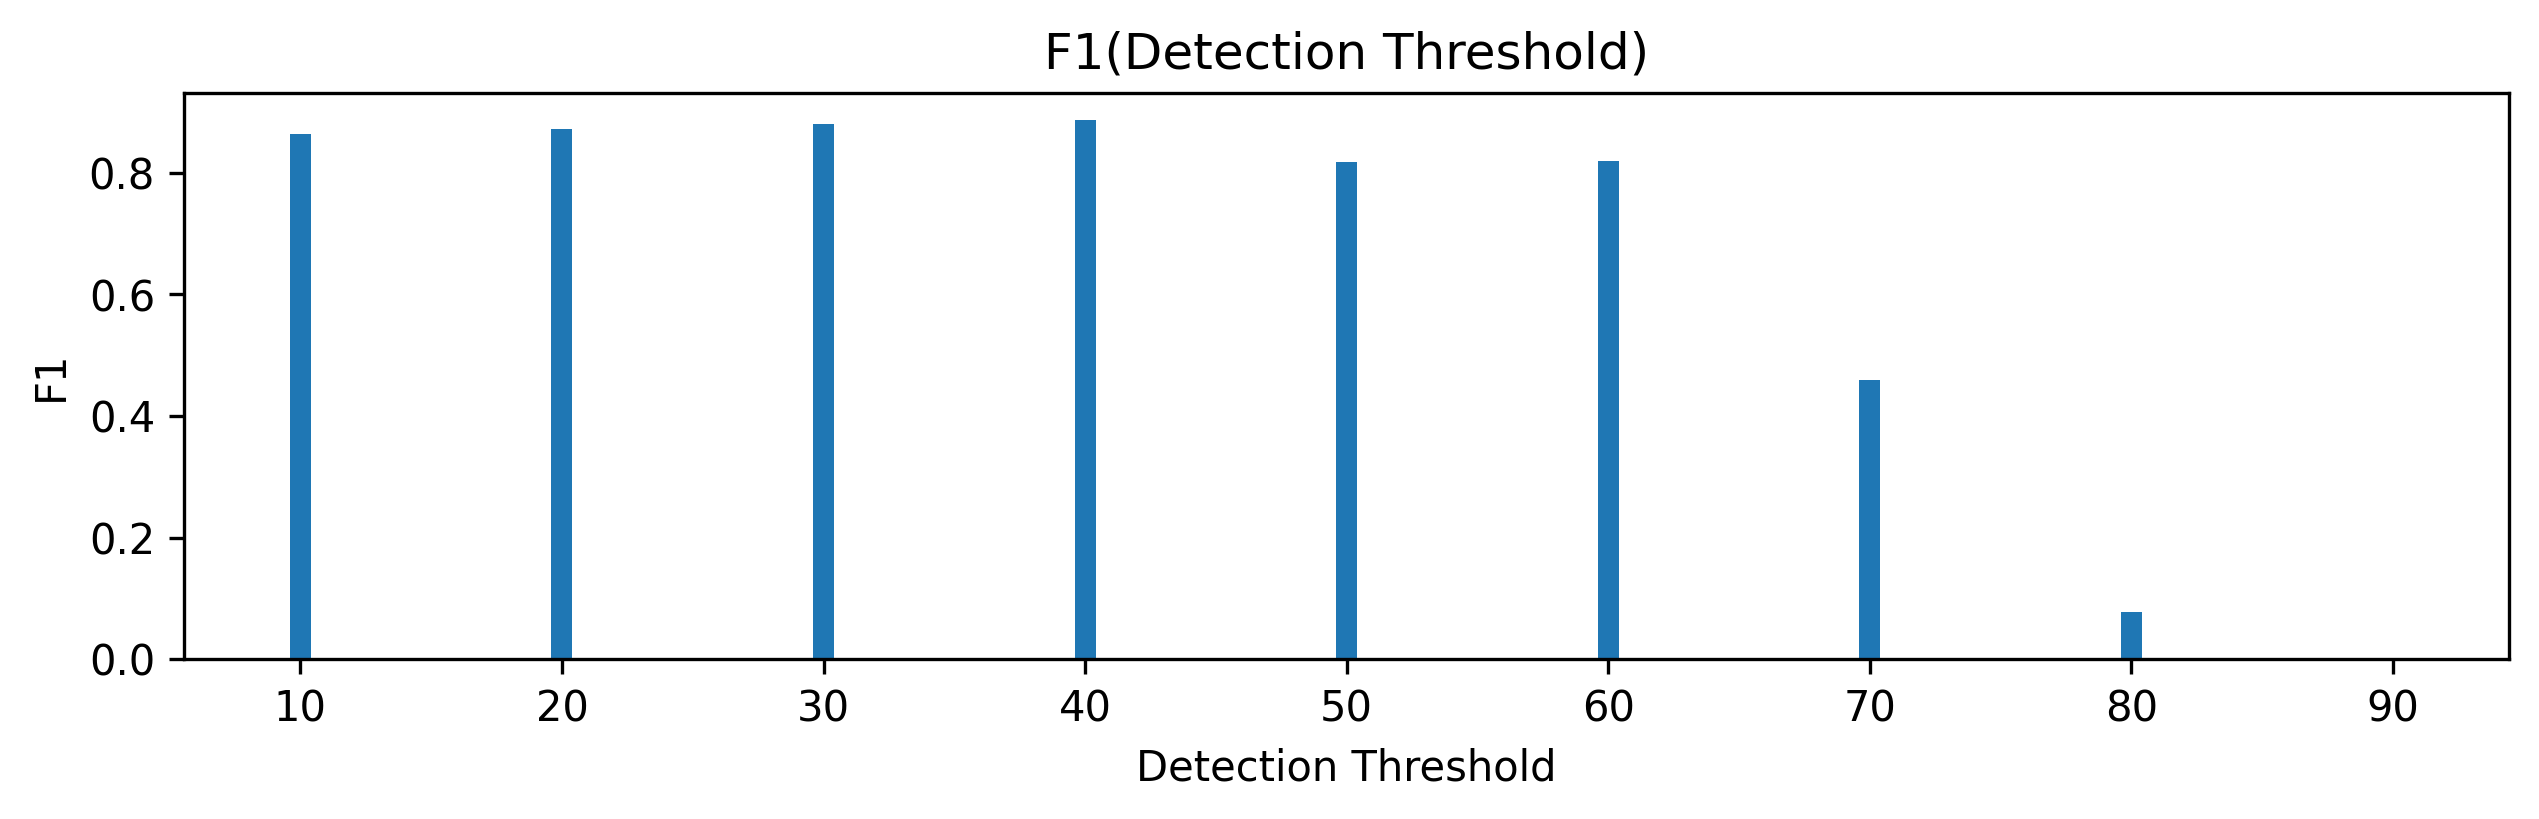

In [10]:
shift = 0
full_test_circle(df,test_babacan_multiclass_path,f'{model_name}-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                all_scores=True,averages=True,split_shift=shift,evaluator=our_evaluator_top1)

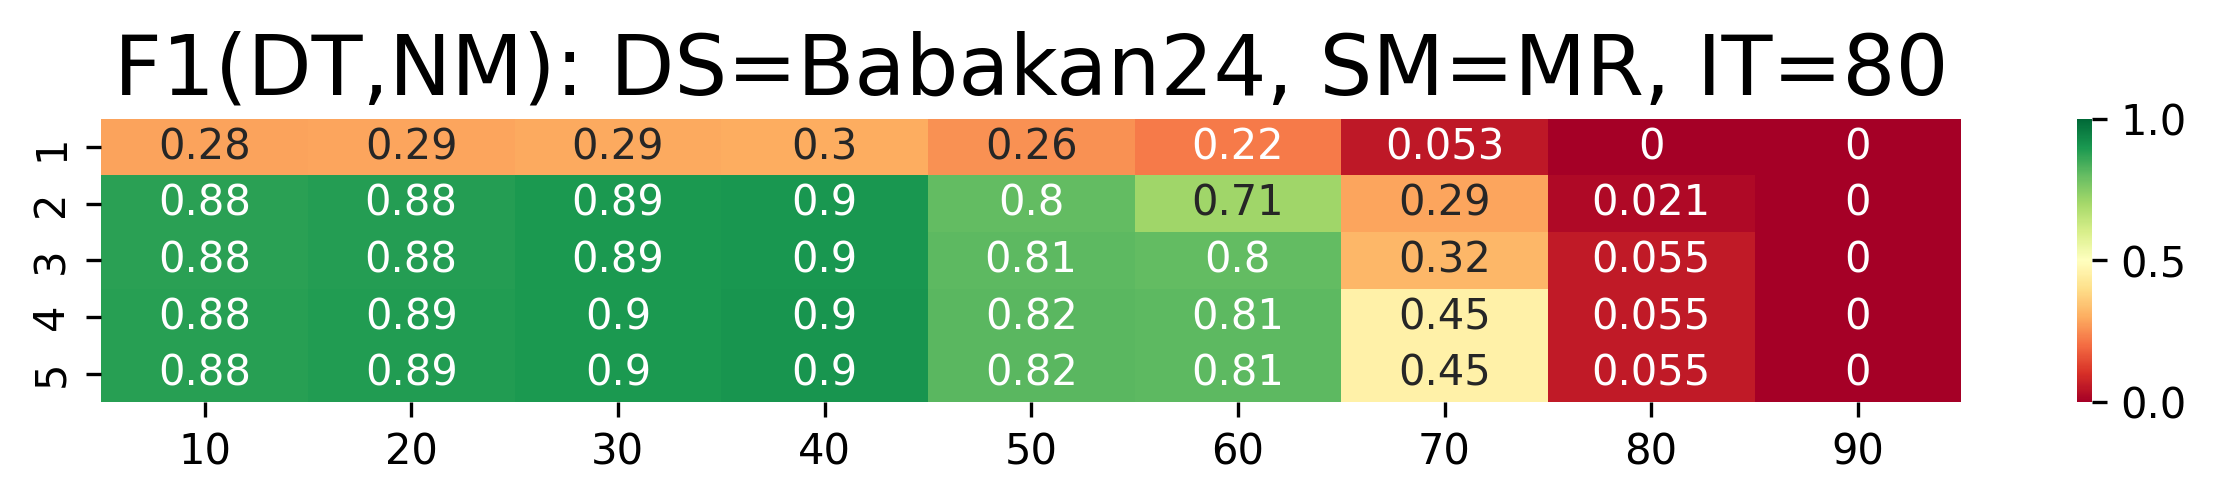

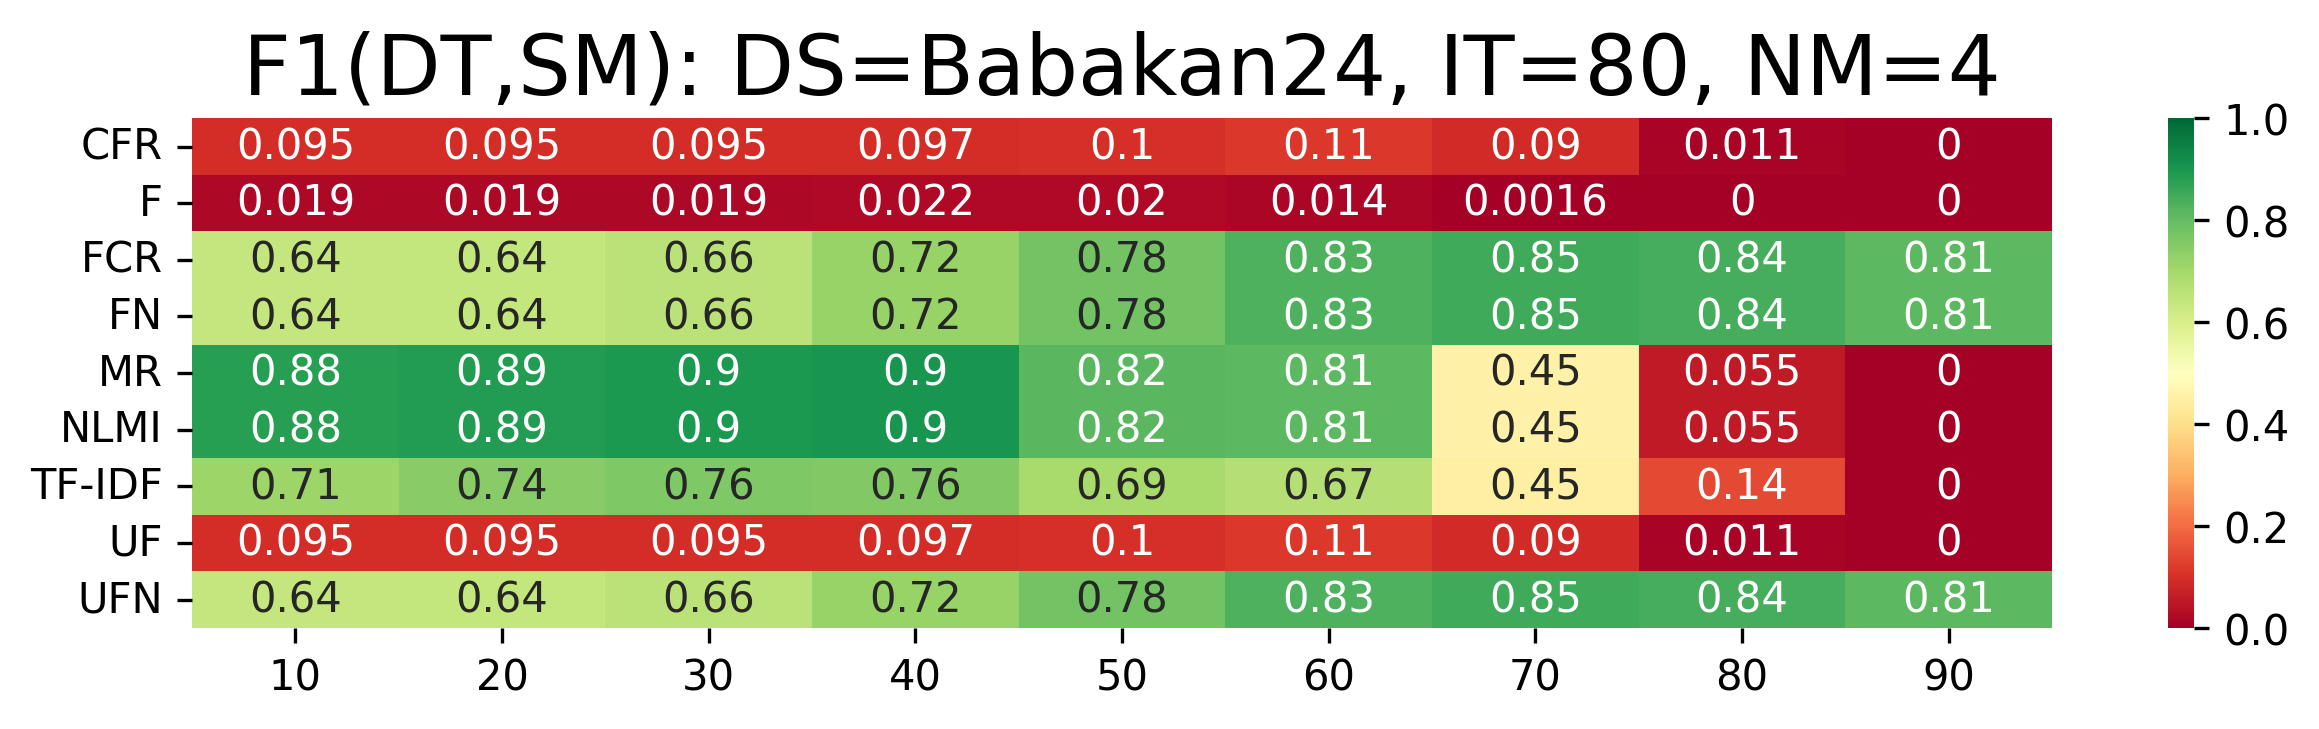

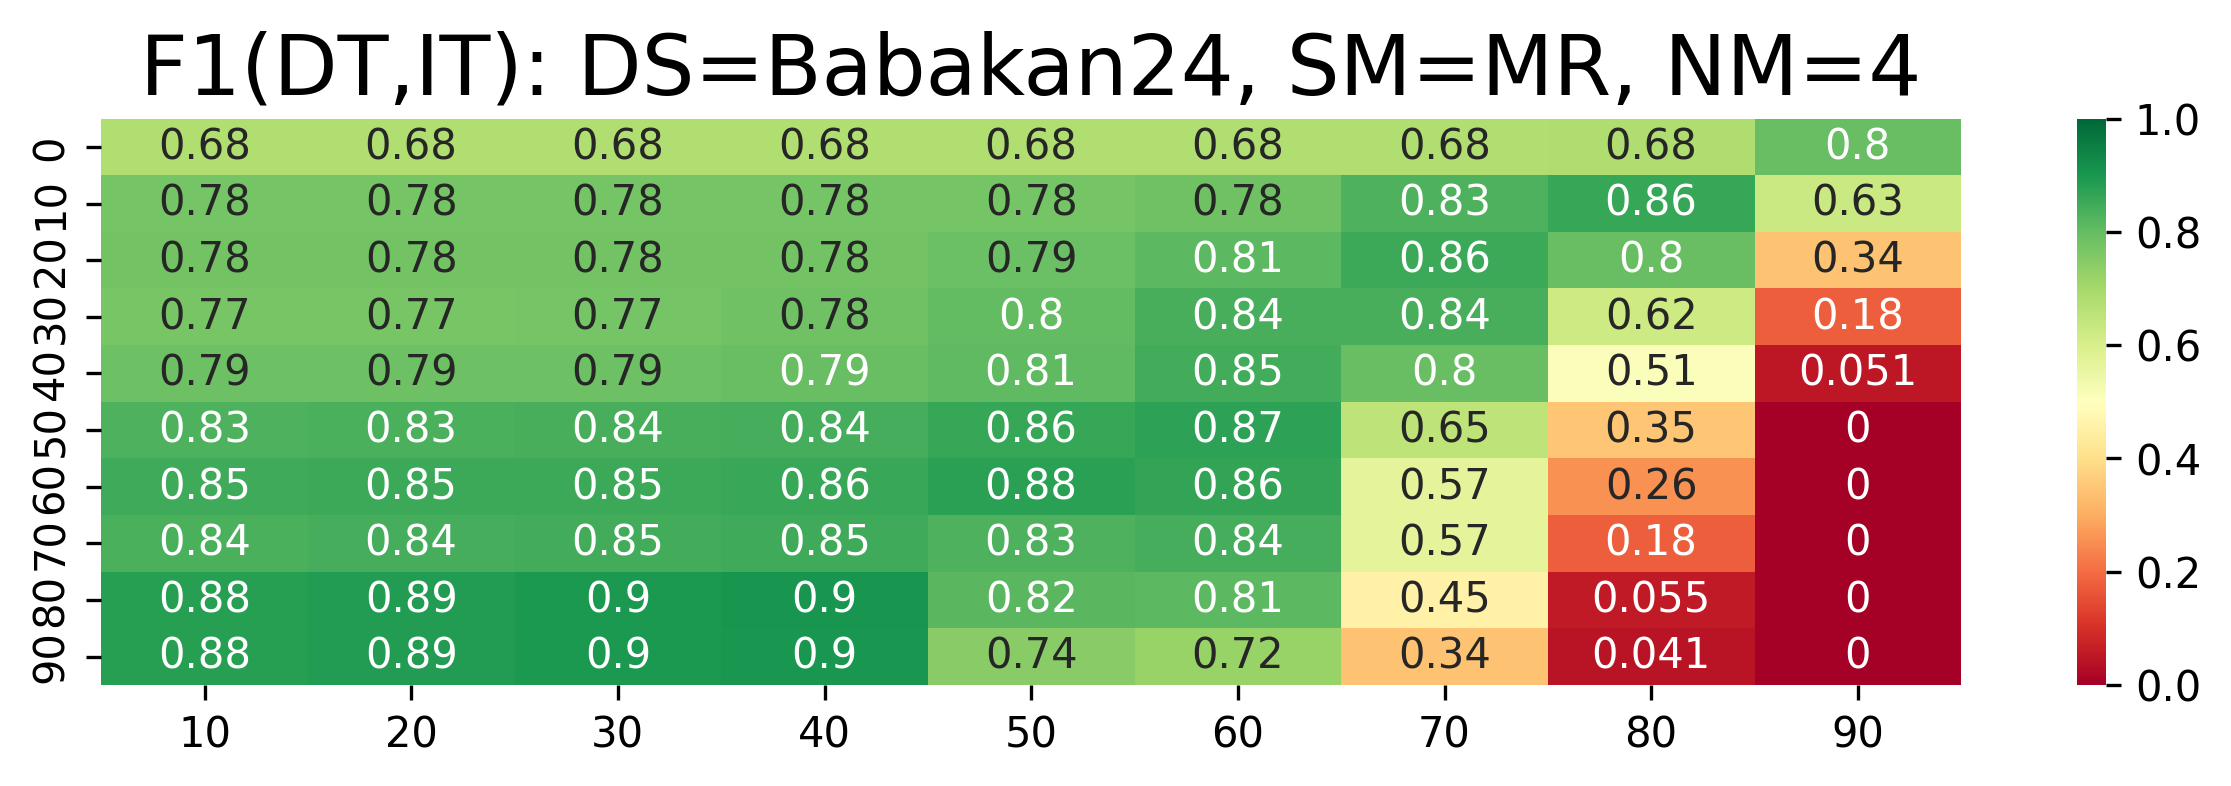

In [11]:
m = build_triple_matrix(summary,0,3,{2:SM,1:IT},6,n_max_values,detection_thresholds)
matrix_plot(n_max_values, detection_thresholds, m, 1.0, title = f'F1(DT,NM): DS={DS}, SM={SM}, IT={IT}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)

m = build_triple_matrix(summary,2,3,{0:NM,1:IT},6,selection_metrics,detection_thresholds)
matrix_plot(sorted(selection_metrics), detection_thresholds, m, 1.0, title = f'F1(DT,SM): DS={DS}, IT={IT}, NM={NM}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)

m = build_triple_matrix(summary,1,3,{0:NM,2:SM},6,inclusion_thresholds, detection_thresholds)
matrix_plot(sorted(inclusion_thresholds), detection_thresholds, m, 1.0, title = f'F1(DT,IT): DS={DS}, SM={SM}, NM={NM}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 300, width = 10)


## Summary

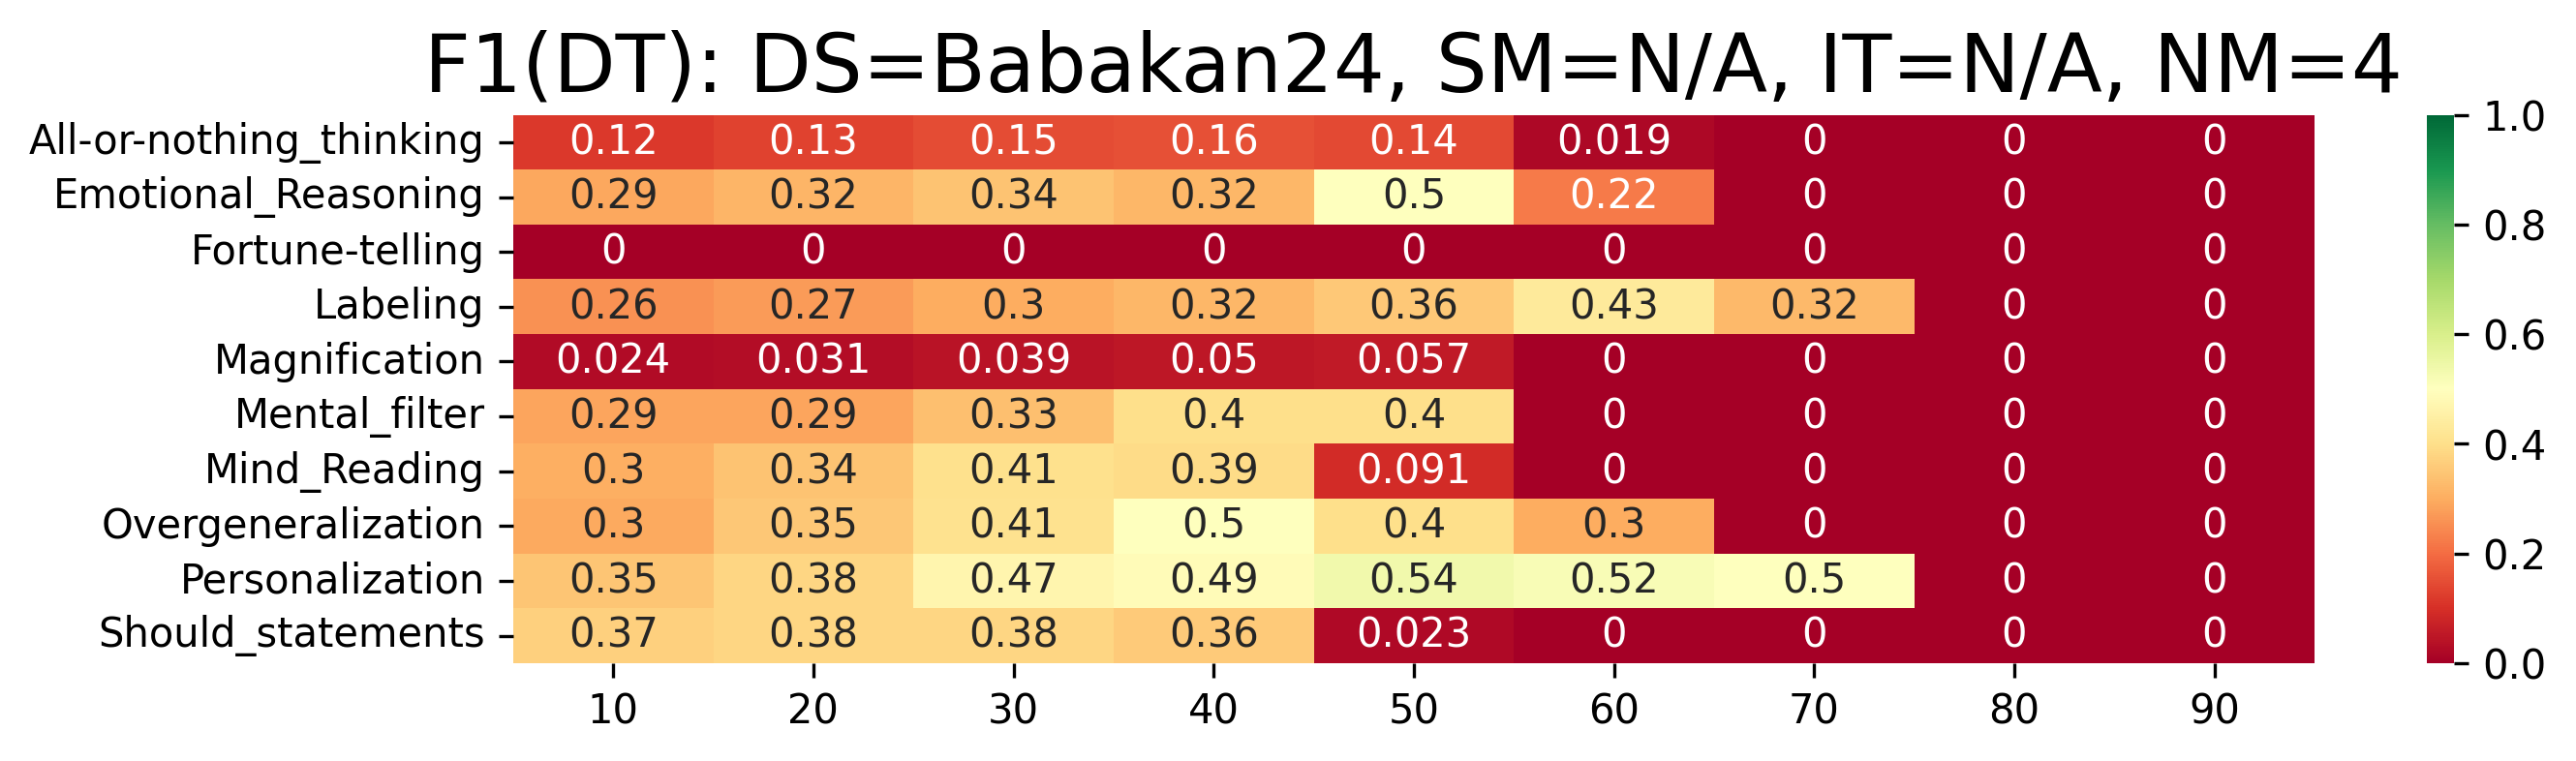

(4, 'N/A', 'N/A', 40, 0.29852150491406354, {'All-or-nothing_thinking': 0.15537848605577687, 'Emotional_Reasoning': 0.32, 'Fortune-telling': 0, 'Labeling': 0.31967213114754106, 'Magnification': 0.05, 'Mental_filter': 0.4, 'Mind_Reading': 0.39285714285714285, 'Overgeneralization': 0.5, 'Personalization': 0.4880952380952381, 'Should_statements': 0.3592120509849363})
['All-or-nothing_thinking', 'Emotional_Reasoning', 'Fortune-telling', 'Labeling', 'Magnification', 'Mental_filter', 'Mind_Reading', 'Overgeneralization', 'Personalization', 'Should_statements']
[0.16, 0.32, 0, 0.32, 0.05, 0.4, 0.39, 0.5, 0.49, 0.36]


In [12]:
all_metricsmap = {'All-or-nothing_thinking':'dichotomous-reasoning',
              'Fortune-telling':'fortune-telling',
              'Mental_filter':'mental-filtering',
              'Overgeneralization':'overgeneralizing',
              'Labeling':'labeling',
              'Mind_Reading':'mindreading',
              'Personalization':'personalizing',
              'Emotional_Reasoning':'emotional-reasoning',
              'Magnification':'magnification',
              'Should_statements':'should-statement'}

def language_metrics(lang,metrics_filenames,path):
    metrics = {}
    for m in metrics_filenames:
        filename = metrics_filenames[m] if type(metrics_filenames) == dict else m
        metrics[m] = path + lang + '/' + filename + '.txt'
    return metrics

tm_base = TextMetrics(language_metrics('',all_metricsmap,path='data/models/distortions/ours')
                  ,encoding="utf-8",metric_logarithmic=True,debug=False)

detection_thresholds = [10,20,30,40,50,60,70,80,90]

accumulator = []
evaluate_metrics(tm_base, df, 'N/A', detection_thresholds, DS, list(all_metricsmap), n_max=4, 
                selection_metric = 'N/A', f1_score=True, evaluator=our_evaluator_top1, accumulator=accumulator)

best = sorted(accumulator, key=lambda x: (-x[4]))[0]
print(best)
labels = sorted(list(best[5]))
print(labels)
numbers_arinicheva = [round(best[5][label],2) for label in labels]
print(numbers_arinicheva)

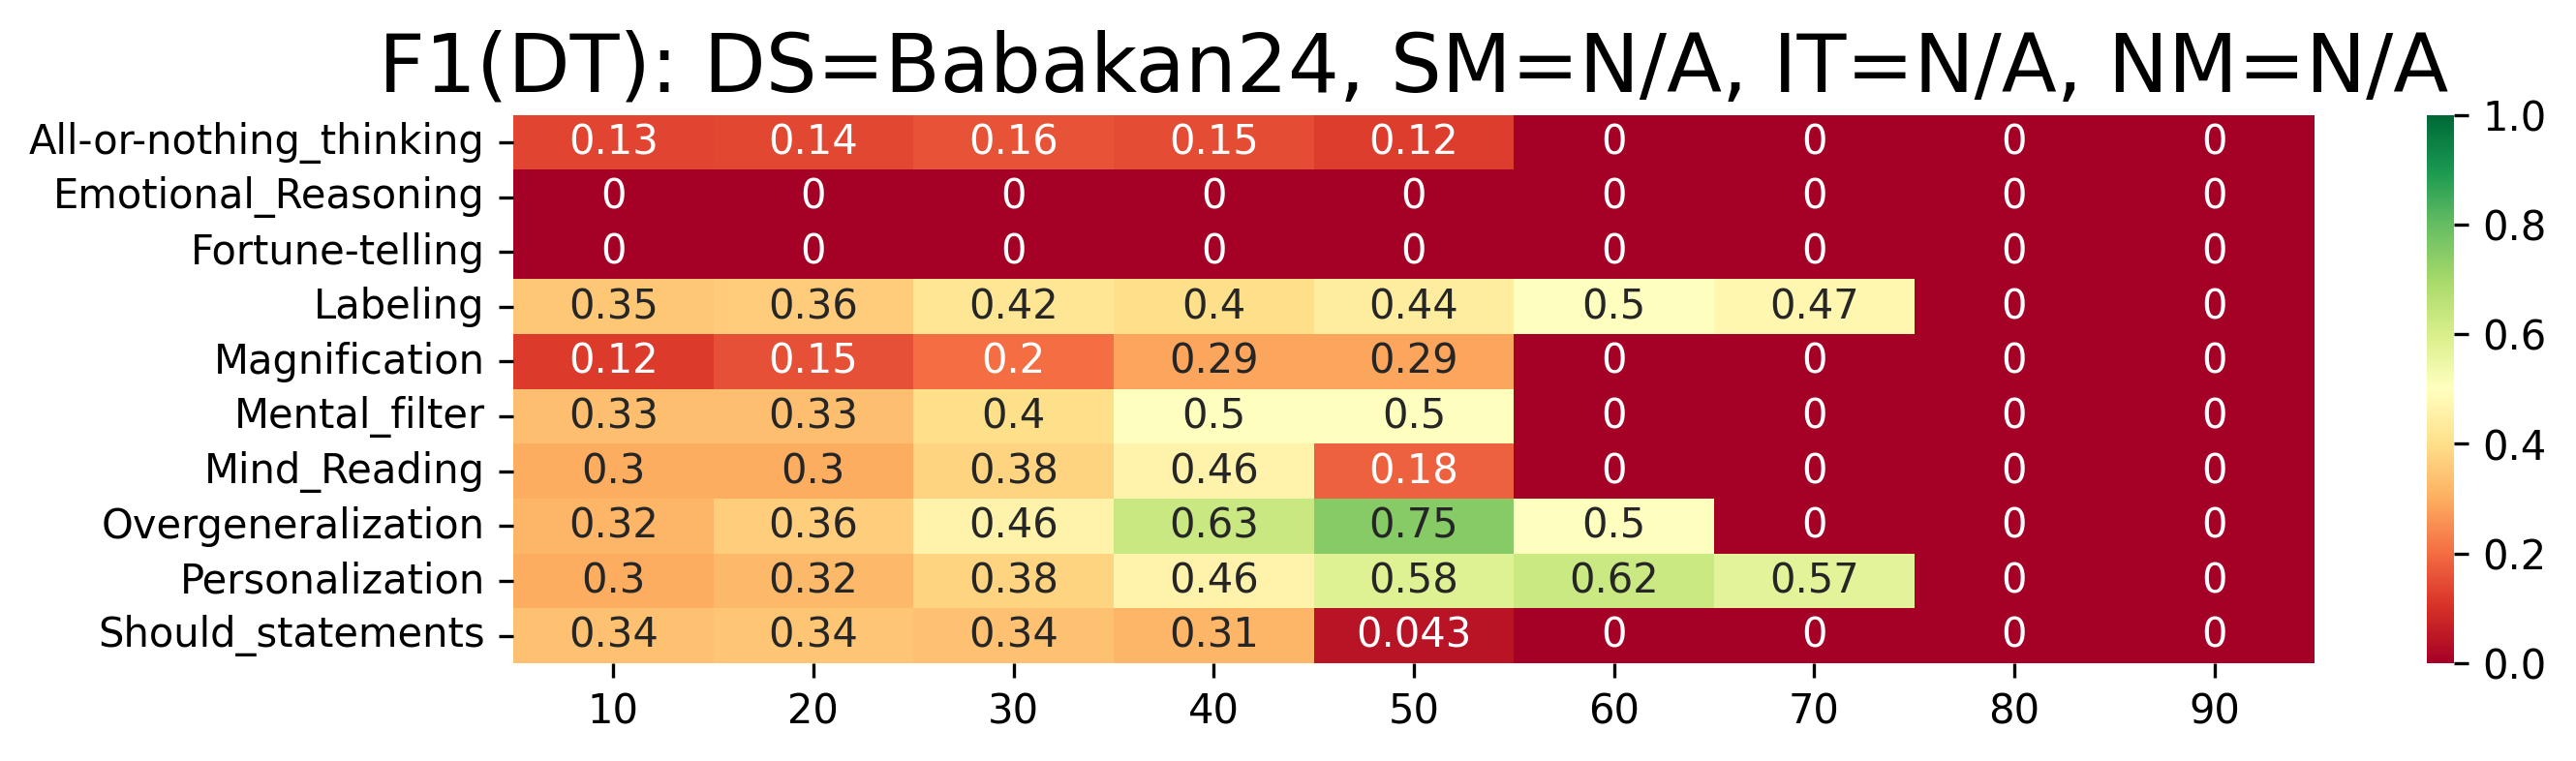

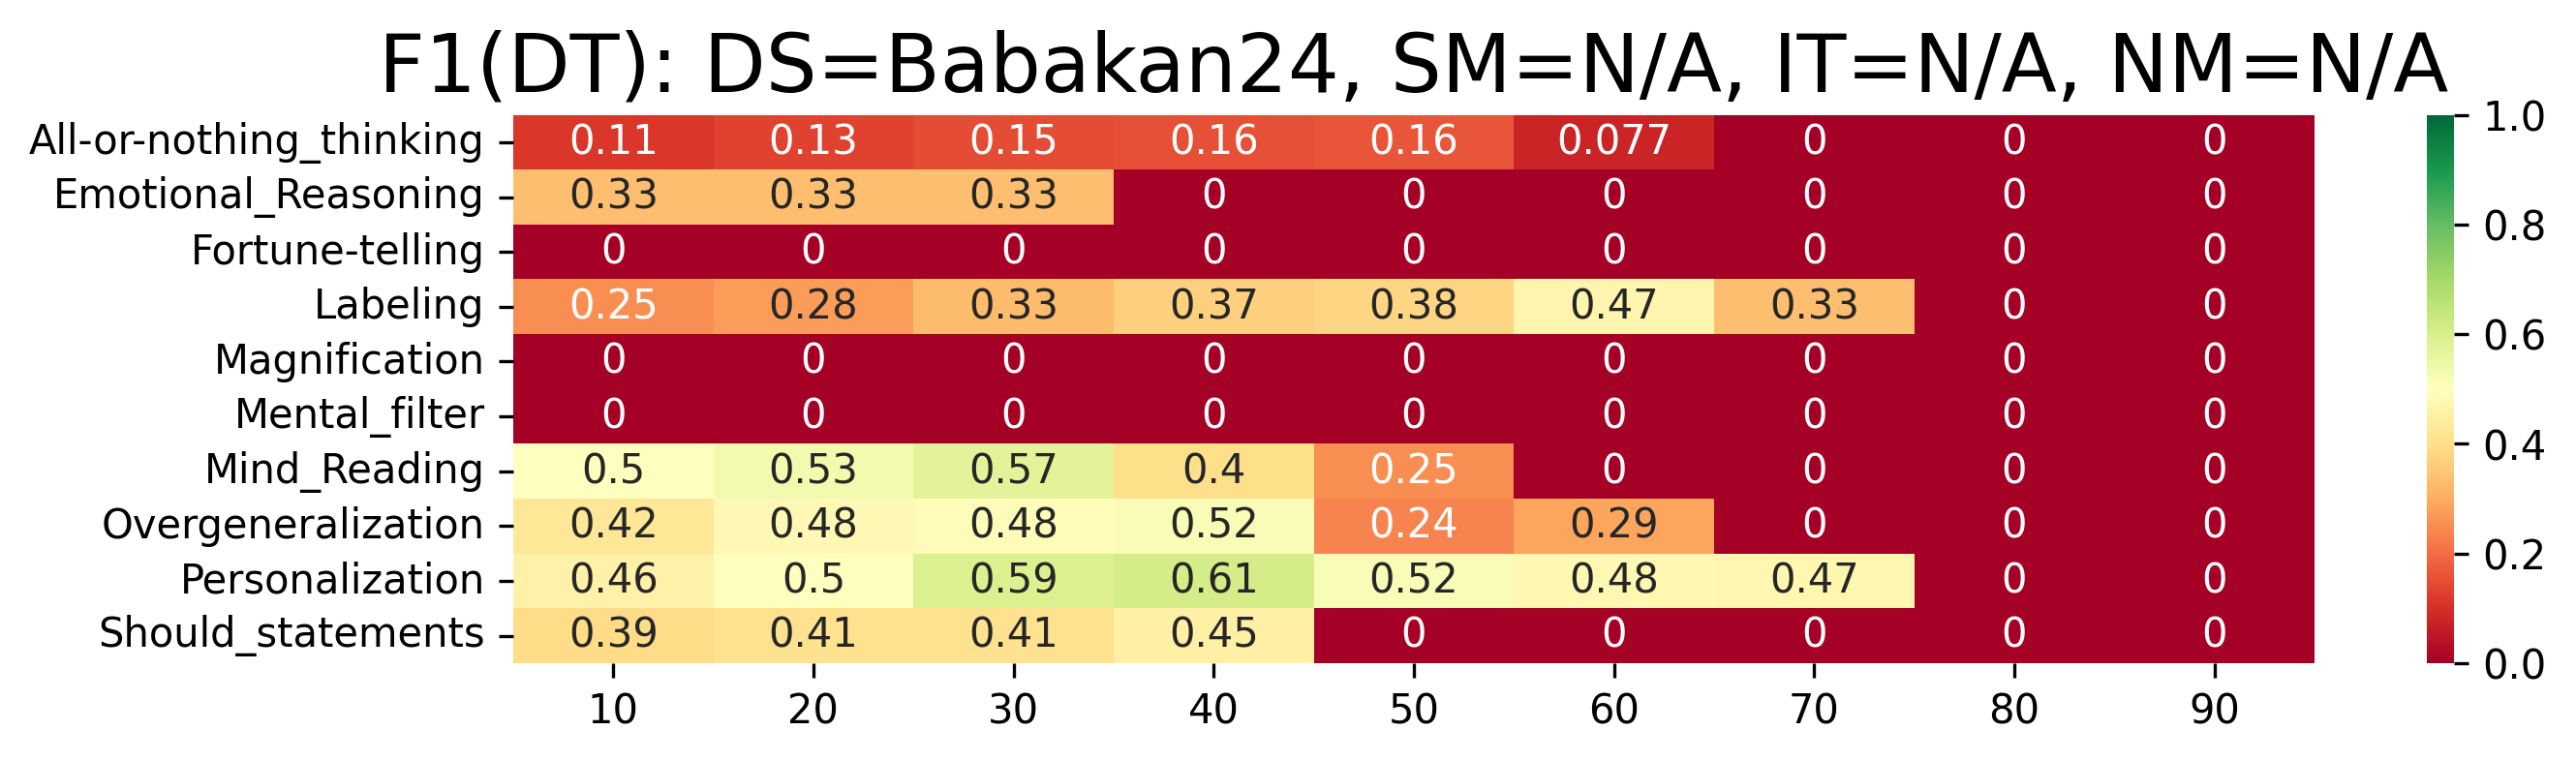

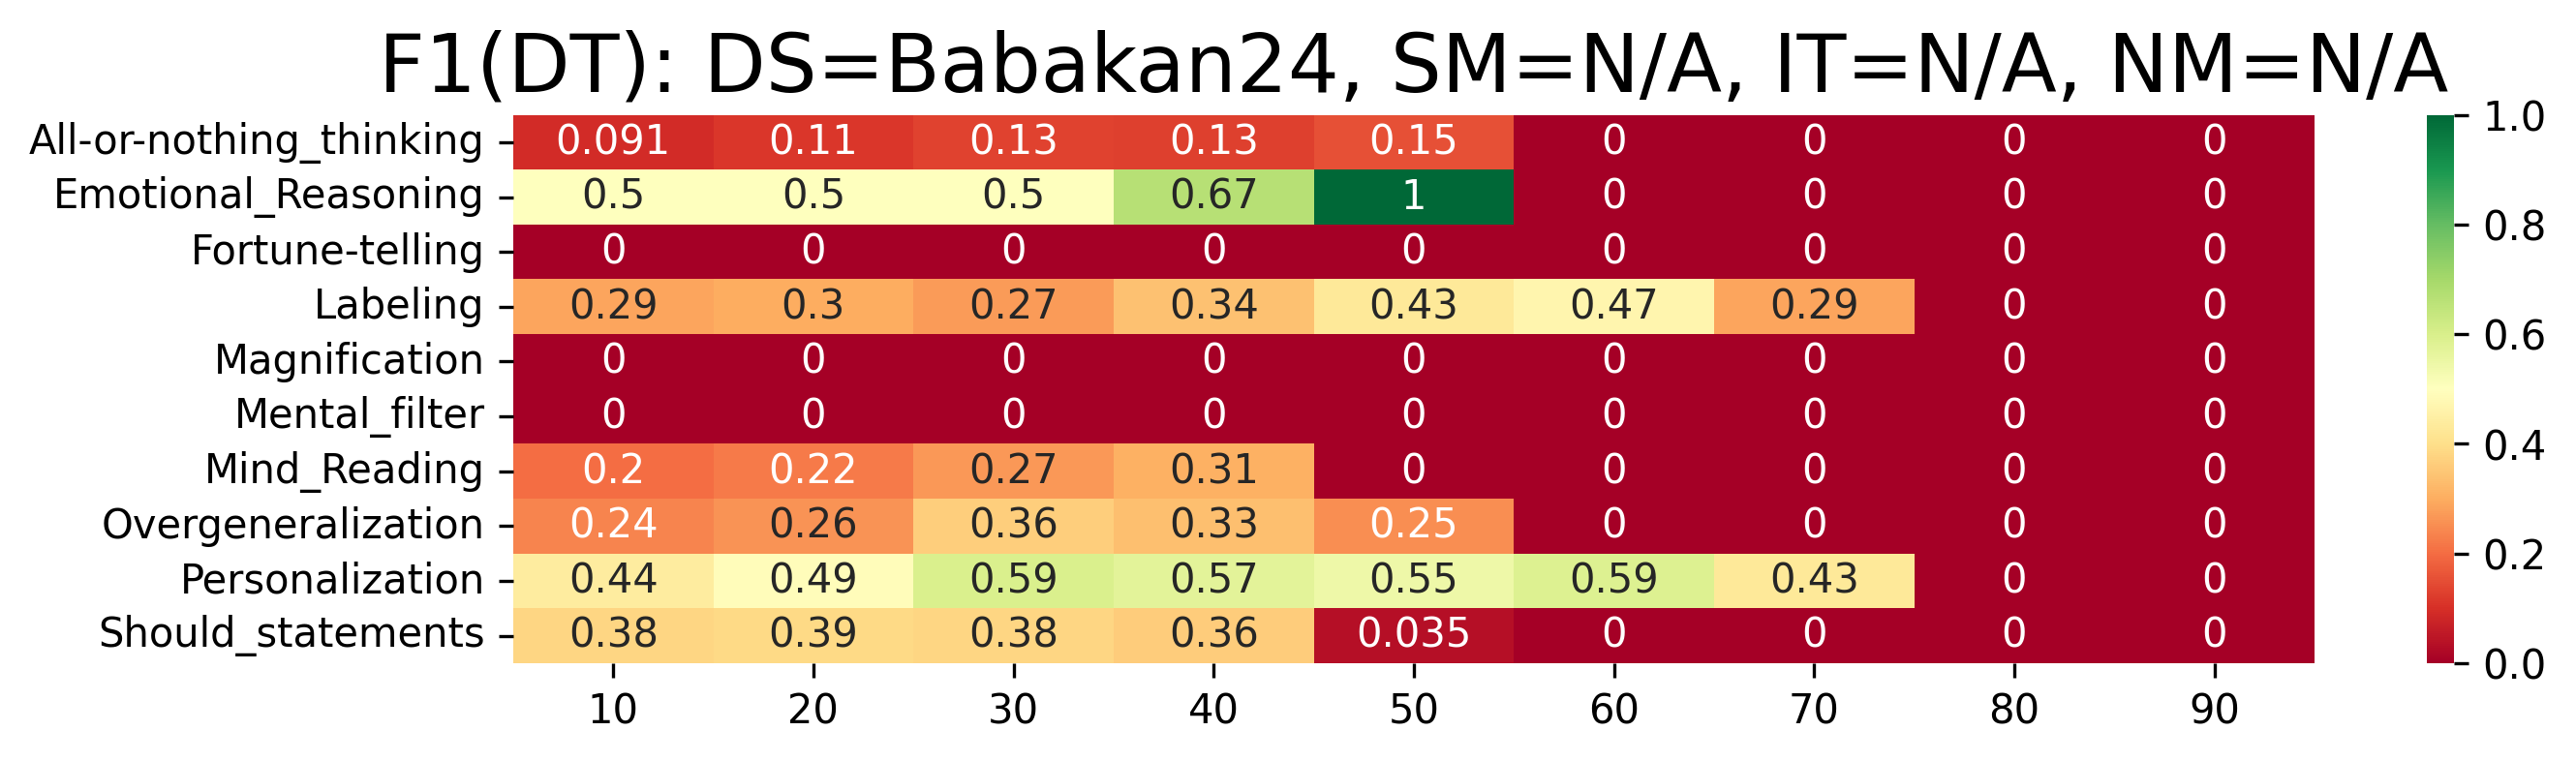

In [13]:
validation_fraction = 5
results_base = []
for shift in splits:
    test_df  = df[(df.index + shift) % validation_fraction == 0]
    accumulator_base = []
    evaluate_metrics(tm_base, test_df, 'N/A', detection_thresholds, DS, list(all_metricsmap), n_max='N/A', 
                selection_metric = 'N/A', f1_score=True, evaluator=our_evaluator_top1, accumulator=accumulator_base)
    results_base.append(accumulator_base)

In [14]:
summary_base = []
for l1,l2,l3 in zip(results_base[0],results_base[1],results_base[2]):
    summary_base.append( l1[0:4] + agg_min_max_avg_mpe((l1[4],l2[4],l3[4])))
summary_base = sorted(summary_base, key=lambda x: (-x[6],x[3])) # sort by -F1avg, DT
summary_base[0]

('N/A',
 'N/A',
 'N/A',
 40,
 0.2499479429528691,
 0.31990777136623677,
 0.2801871991998125,
 9.450960472108736)

In [15]:
base_babakan = {'Mind_Reading': 0.8121,
'Overgeneralization': 0.6047,
'Magnification': 0.6483,
'Labelling': 0.8372,
'Personalization': 0.6946,
'Fortune-telling': 0.8193,
'Emotional_Reasoning': 0.6462,
'Mental_filter': 1.0000,
'Should_statements': 1.0000,
'All-or-nothing_thinking': 1.0000,
'Labeling': 0.4167}

numbers_babakan = [round(base_babakan[label],2) for label in labels]
print(numbers_babakan)

[1.0, 0.65, 0.82, 0.42, 0.65, 1.0, 0.81, 0.6, 0.69, 1.0]


4 80 MR 40
Shift=0: train=3623, test=907
Labels count: defaultdict(<class 'int'>, {'Mind_Reading': 349, 'Overgeneralization': 353, 'Magnification': 322, 'Labeling': 283, 'Personalization': 283, 'Fortune-telling': 268, 'Emotional_Reasoning': 272, 'Mental_filter': 257, 'Should_statements': 248, 'All-or-nothing_thinking': 236, 'No_Distortion': 752})


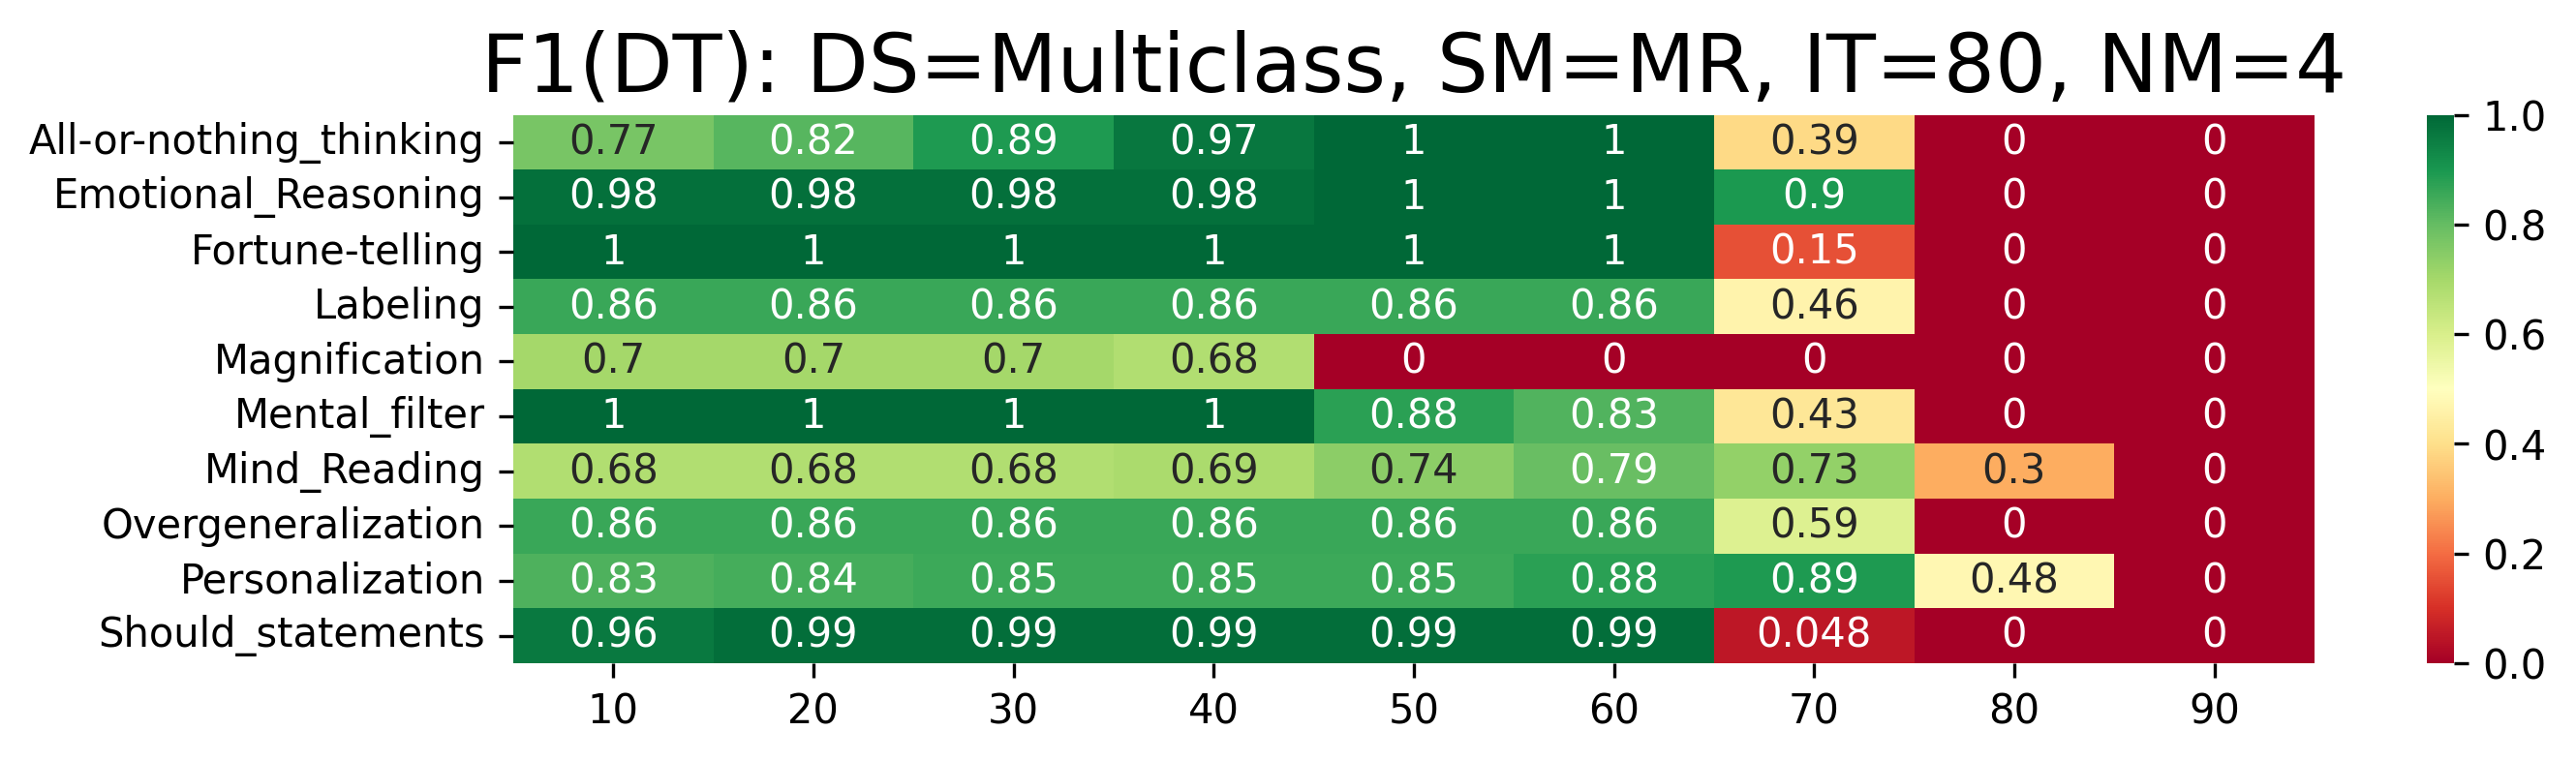

(4, 80, 'MR', 40, 0.8871984818076772, {'All-or-nothing_thinking': 0.9666666666666666, 'Emotional_Reasoning': 0.9818181818181818, 'Fortune-telling': 1.0, 'Labeling': 0.8571428571428571, 'Magnification': 0.6785714285714285, 'Mental_filter': 1.0, 'Mind_Reading': 0.6896551724137931, 'Overgeneralization': 0.8571428571428571, 'Personalization': 0.8533333333333333, 'Should_statements': 0.9876543209876543})
['All-or-nothing_thinking', 'Emotional_Reasoning', 'Fortune-telling', 'Labeling', 'Magnification', 'Mental_filter', 'Mind_Reading', 'Overgeneralization', 'Personalization', 'Should_statements']
[0.97, 0.98, 1.0, 0.86, 0.68, 1.0, 0.69, 0.86, 0.85, 0.99]


In [16]:
print(NM,IT,SM,DT) # 2 10 FCR 70
shift = 0

accumulator = []
full_test_circle(df,test_babacan_multiclass_path,f'{model_name}-{shift+1}',
                validation_fraction=5,inclusion_thresholds=[IT],
                detection_thresholds=detection_thresholds,n_max=NM, selection_metrics = [SM],
                f1_score=True, split_shift=shift, evaluator=our_evaluator_top1, accumulator=accumulator)

best = sorted(accumulator, key=lambda x: (-x[4]))[0]
print(best)
labels = sorted(list(best[5]))
print(labels)
numbers_ours = [round(best[5][label],2) for label in labels]
print(numbers_ours)

In [17]:
metric_names = labels
model_metrics = {
'babakan25':   numbers_babakan,
'arinicheva25':   numbers_arinicheva,
'ours25': numbers_ours
}
fig = go.Figure()
for i in range(len(labels)):
    fig.add_trace(go.Bar(
        name=metric_names[i],
        x=list(model_metrics), y=[model_metrics[m][i] for m in model_metrics],
    ))
fig.update_layout(
    barmode='group', # Group bars by model
    title='F1 by model and label', # Add a title
    xaxis_title='Model', # Label the x-axis
    yaxis_title='F1', # Label the y-axis
    hovermode='closest' # Improve hover behavior
)
fig.show()


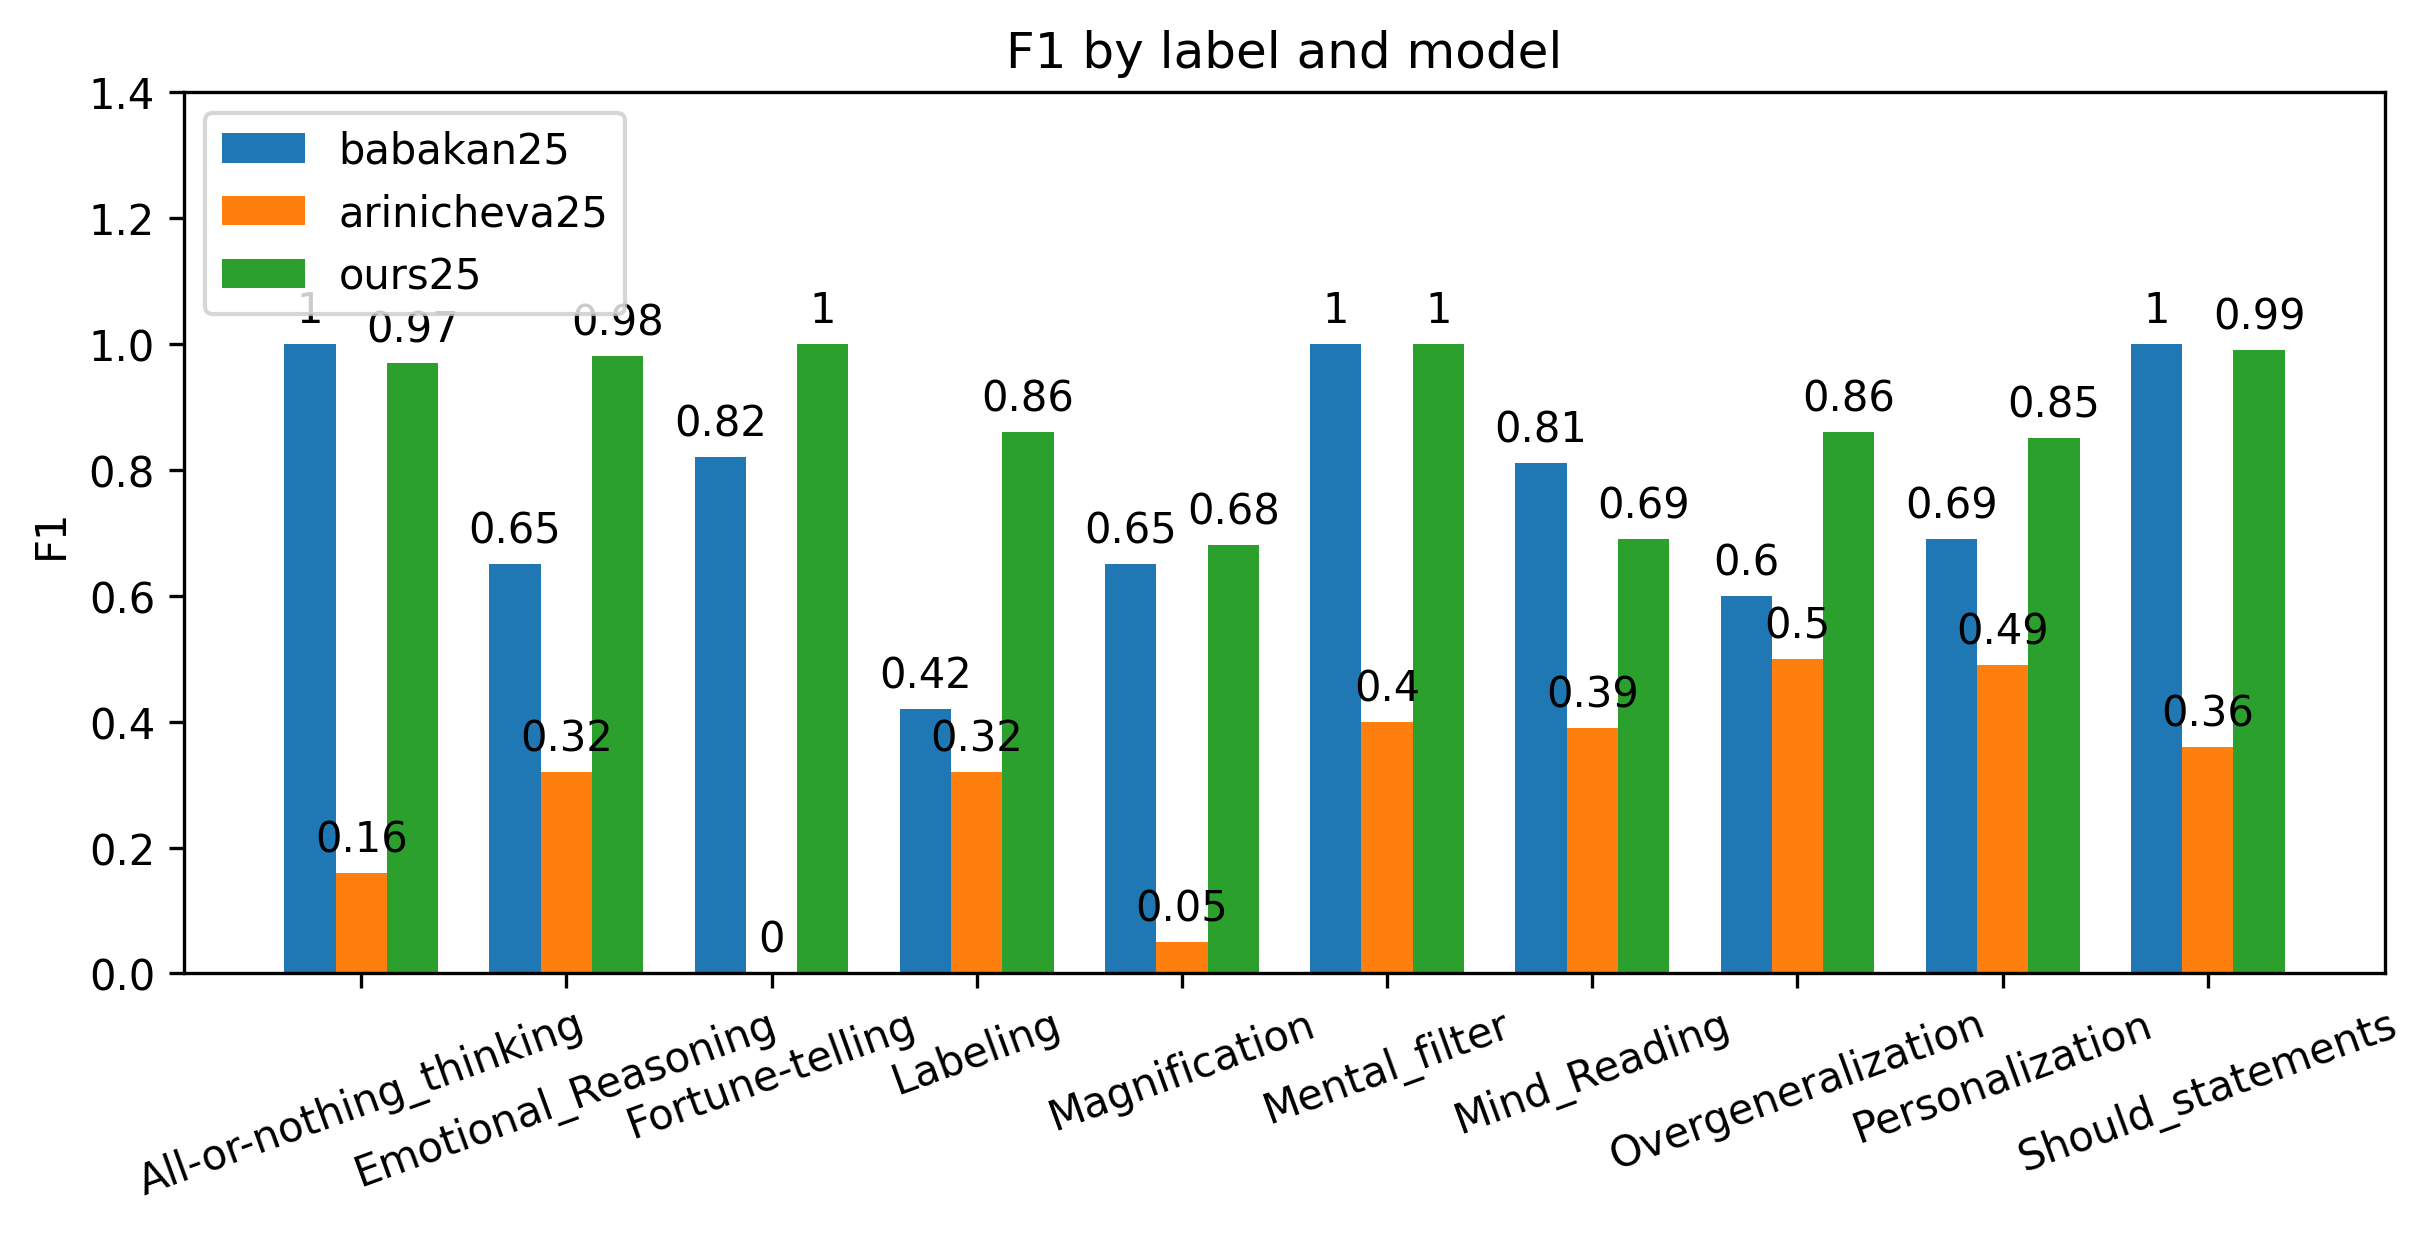

In [18]:
values = {
'babakan25':   numbers_babakan,
'arinicheva25':   numbers_arinicheva,
'ours25': numbers_ours
}

plt.rcParams["figure.figsize"] = (8,4)

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1')
ax.set_title('F1 by label and model')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left')#, ncols=3)
ax.set_ylim(0, 1.4)
ax.tick_params(axis='x', rotation=20)
fig.set_dpi(300)

plt.show()

F1 babakan25: 0.7677
F1 arinicheva25: 0.2801871991998125%
F1 ours25: 0.9027830220931646%
MPE arinicheva25: 9.450960472108736%
MPE ours25: 1.1508516741452492%


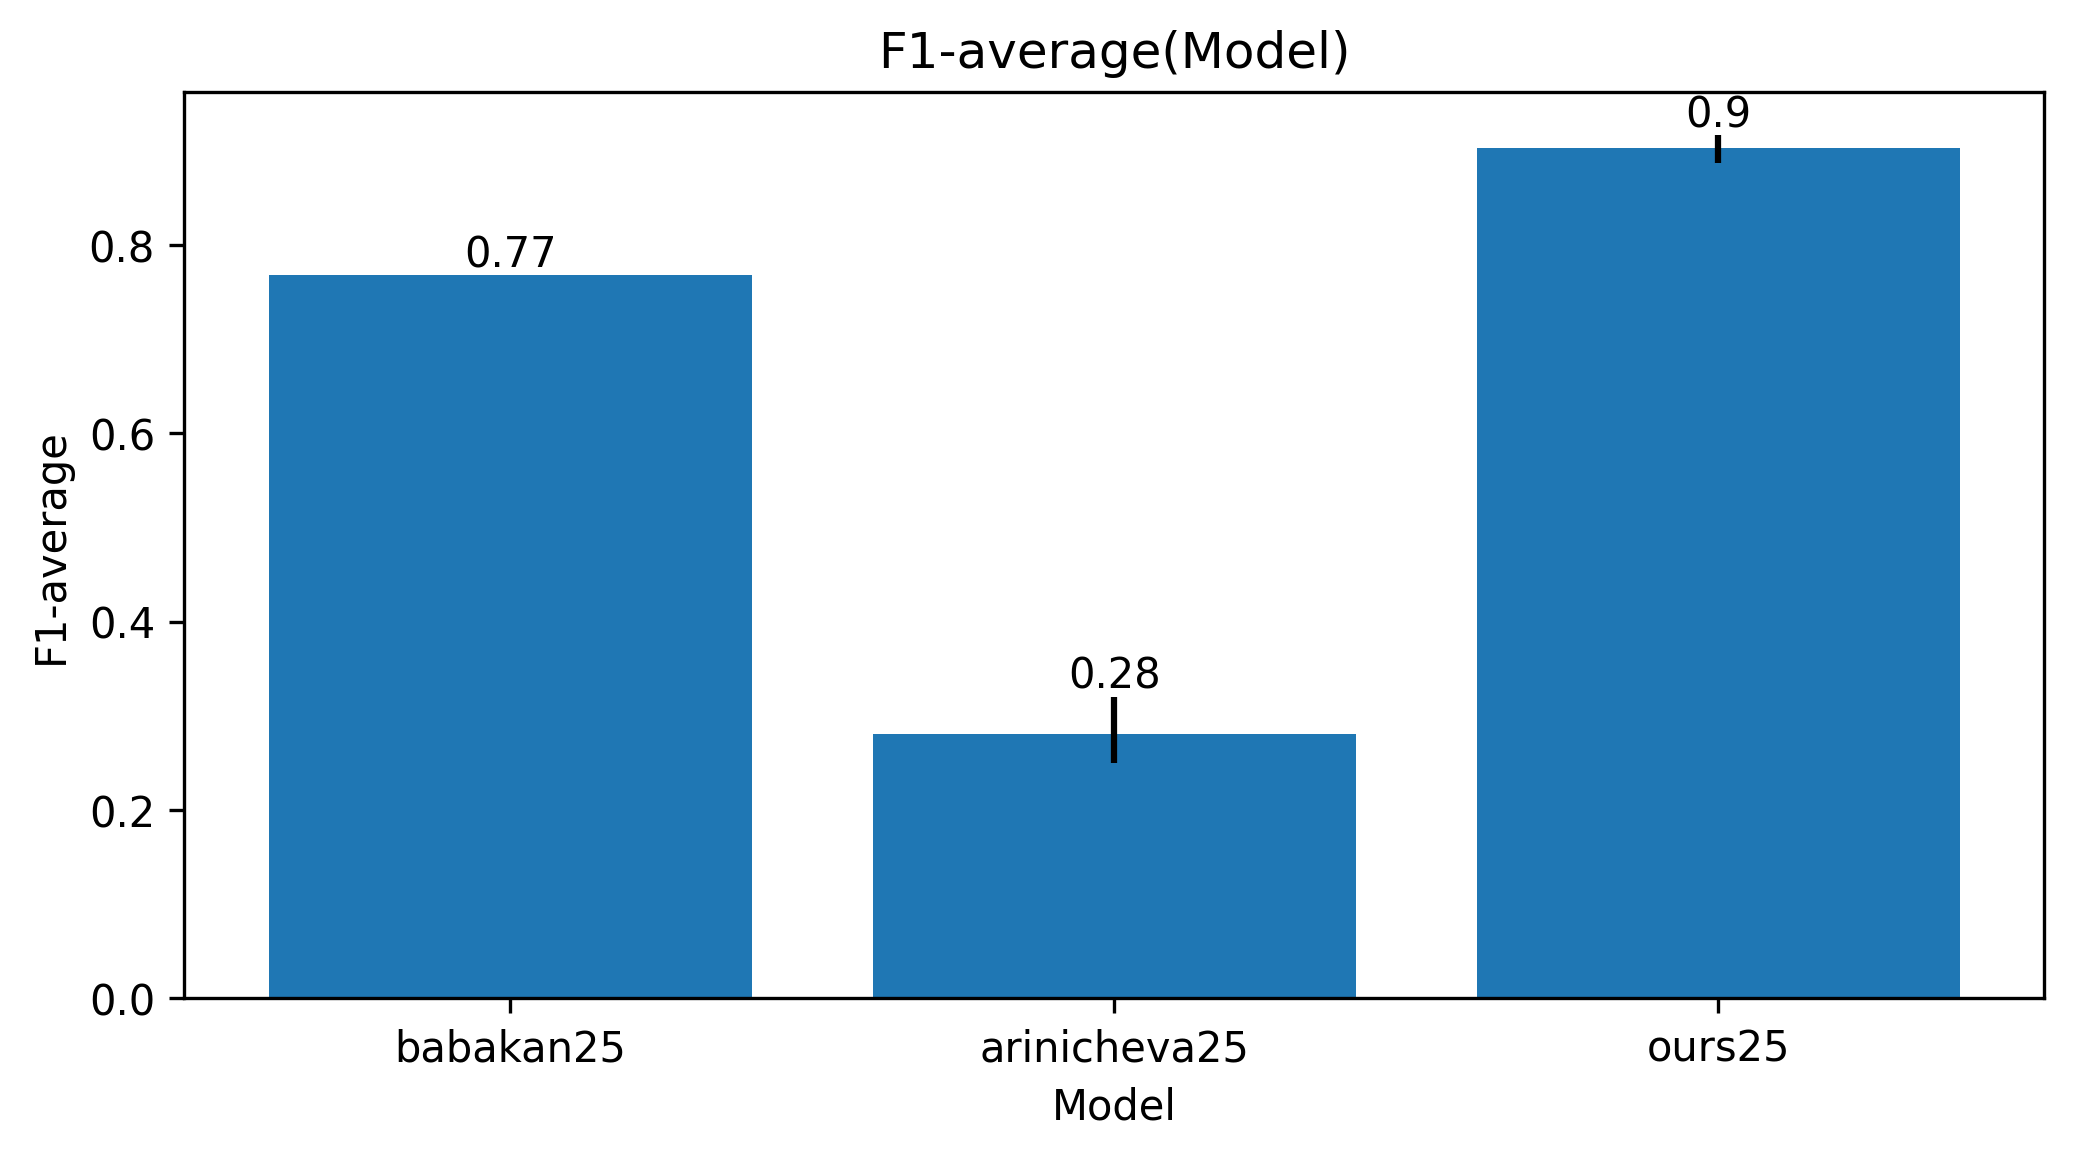

In [19]:
# https://dergipark.org.tr/tr/download/article-file/3865878, page 7
print(f'F1 babakan25: 0.7677')
print(f'F1 arinicheva25: {summary_base[0][6]}%')
print(f'F1 ours25: {summary[0][6]}%')
print(f'MPE arinicheva25: {summary_base[0][7]}%')
print(f'MPE ours25: {summary[0][7]}%')
plot_bar_from_list_minmax('Model',['babakan25','arinicheva25','ours25'],
                'F1-average',[0.7677,summary_base[0][6],summary[0][6]],
                minmax=[(0.7677,0.7677),(summary_base[0][4],summary_base[0][5]),(summary[0][4],summary[0][5])])

In [20]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'7:18:20.507020'